In [1]:
using DelimitedFiles, LinearAlgebra, Statistics, Random, DataFrames
using RestrictedBoltzmannMachines: mean_from_inputs, sample_from_inputs, inputs_h_from_v, sample_h_from_v
using RestrictedBoltzmannMachines: RBM, Potts, Binary, log_pseudolikelihood, initialize!, pcd!,
    sample_from_inputs, sample_v_from_v, free_energy, onehot_encode, sample_v_from_h, onehot_decode
using Statistics: mean, cov, std, var, cor

using JLD2: load
using MultivariateStats
using MLJ, MLJLinearModels
using Logging
using Makie
using XLSX
using SequenceLogos
using CairoMakie
using JLD2
using MultivariateStats
using UMAP
using Flux
using Clustering

include("specificity_helpers.jl")
include("LogisticPCA.jl")

example_usage (generic function with 1 method)

CHOOSE WHICH RBM TO ANALYZE FIRST

In [2]:
rbm = load_object("/home/jacopo/PDZ/rbms_fs_correct/Binary_fs_20_correct.jld2")
n_release  = 20

20

IMPORT THE DATASET

In [3]:
filename_1 = "output.txt"
Gogl_seq, classes = filter_lookup_concat("PDZ_2022.xlsx", "PDZ_2022_final.xlsx", 4)


receptor_str, ligand_str, bind_vec = read_binding_file(filename_1)
label_Stiffler = receptor_str .* ligand_str

Stiffler_onehot = one_hot_encode(label_Stiffler, alphabet, alphabet_dict)
Gogl_onehot = one_hot_encode(Gogl_seq, alphabet, alphabet_dict)

sequence_PDZ = one_hot_encode(receptor_str, alphabet, alphabet_dict)


labels = cat(classes, bind_vec, dims=1)
onehot = cat(Gogl_onehot, Stiffler_onehot, dims=3)
labeled_reshape = reshape(onehot, :, size(onehot, 3))

onehot_seq = onehot[:, 1:split_idx, :]
onehot_pep = onehot[:, split_idx+1:end, :]


Skipped rows: 2037


21×10×86082 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0

Take the constraint

In [4]:
pdz_pep_data = load("pdz_pep_matrices_fast.jld2")

V_matrix = pdz_pep_data["V_general"]  # Peptide embedding matrix
U_matrix = pdz_pep_data["U_general"]  # PDZ embedding matrix
Q_interaction = Q_inter(onehot, split_idx, labels)
Q_interaction_centered = Q_inter_centered(onehot, split_idx, labels)
n_singular_vectors = size(V_matrix, 2)
M = Q_interaction * V_matrix
print(size(M))
Q  = reshape(M, length_alphabet, split_idx, n_singular_vectors)


(1701, 5)

21×81×5 Array{Float32, 3}:
[:, :, 1] =
  0.0          0.0        -0.00847619  …   0.0        -0.0401001   0.0
  0.0          0.0         0.0             0.0         0.0         0.0
  0.0          0.0        -0.0325108       0.0         0.0         0.0
 -0.0428987    0.0        -0.157721       -0.091049    0.0        -0.0491913
  0.0          0.0        -0.0114588       0.0         0.0         0.0
  0.0          0.0         0.0         …  -0.0343632   0.0         0.0
  0.0          0.0        -0.0330789      -0.0297042   0.0         0.0
  0.0         -0.201782   -0.0598952      -0.0500427  -0.398372    0.0
  0.0          0.0        -0.0883268      -0.232647    0.0        -0.0193943
  0.0         -0.0209586  -0.0319831      -0.238558   -0.108316   -0.0516892
  0.0         -0.0115253   0.0         …  -0.0101041   0.0        -0.0272197
  0.0          0.0        -0.0553849      -0.0230135   0.0         0.0
  0.0          0.0         0.0             0.0         0.0         0.0
 -0.00691109  

In [5]:
data_Gogl = create_binding_dictionary_Gogl("PDZ_2022.xlsx", "PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("output.txt")


Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


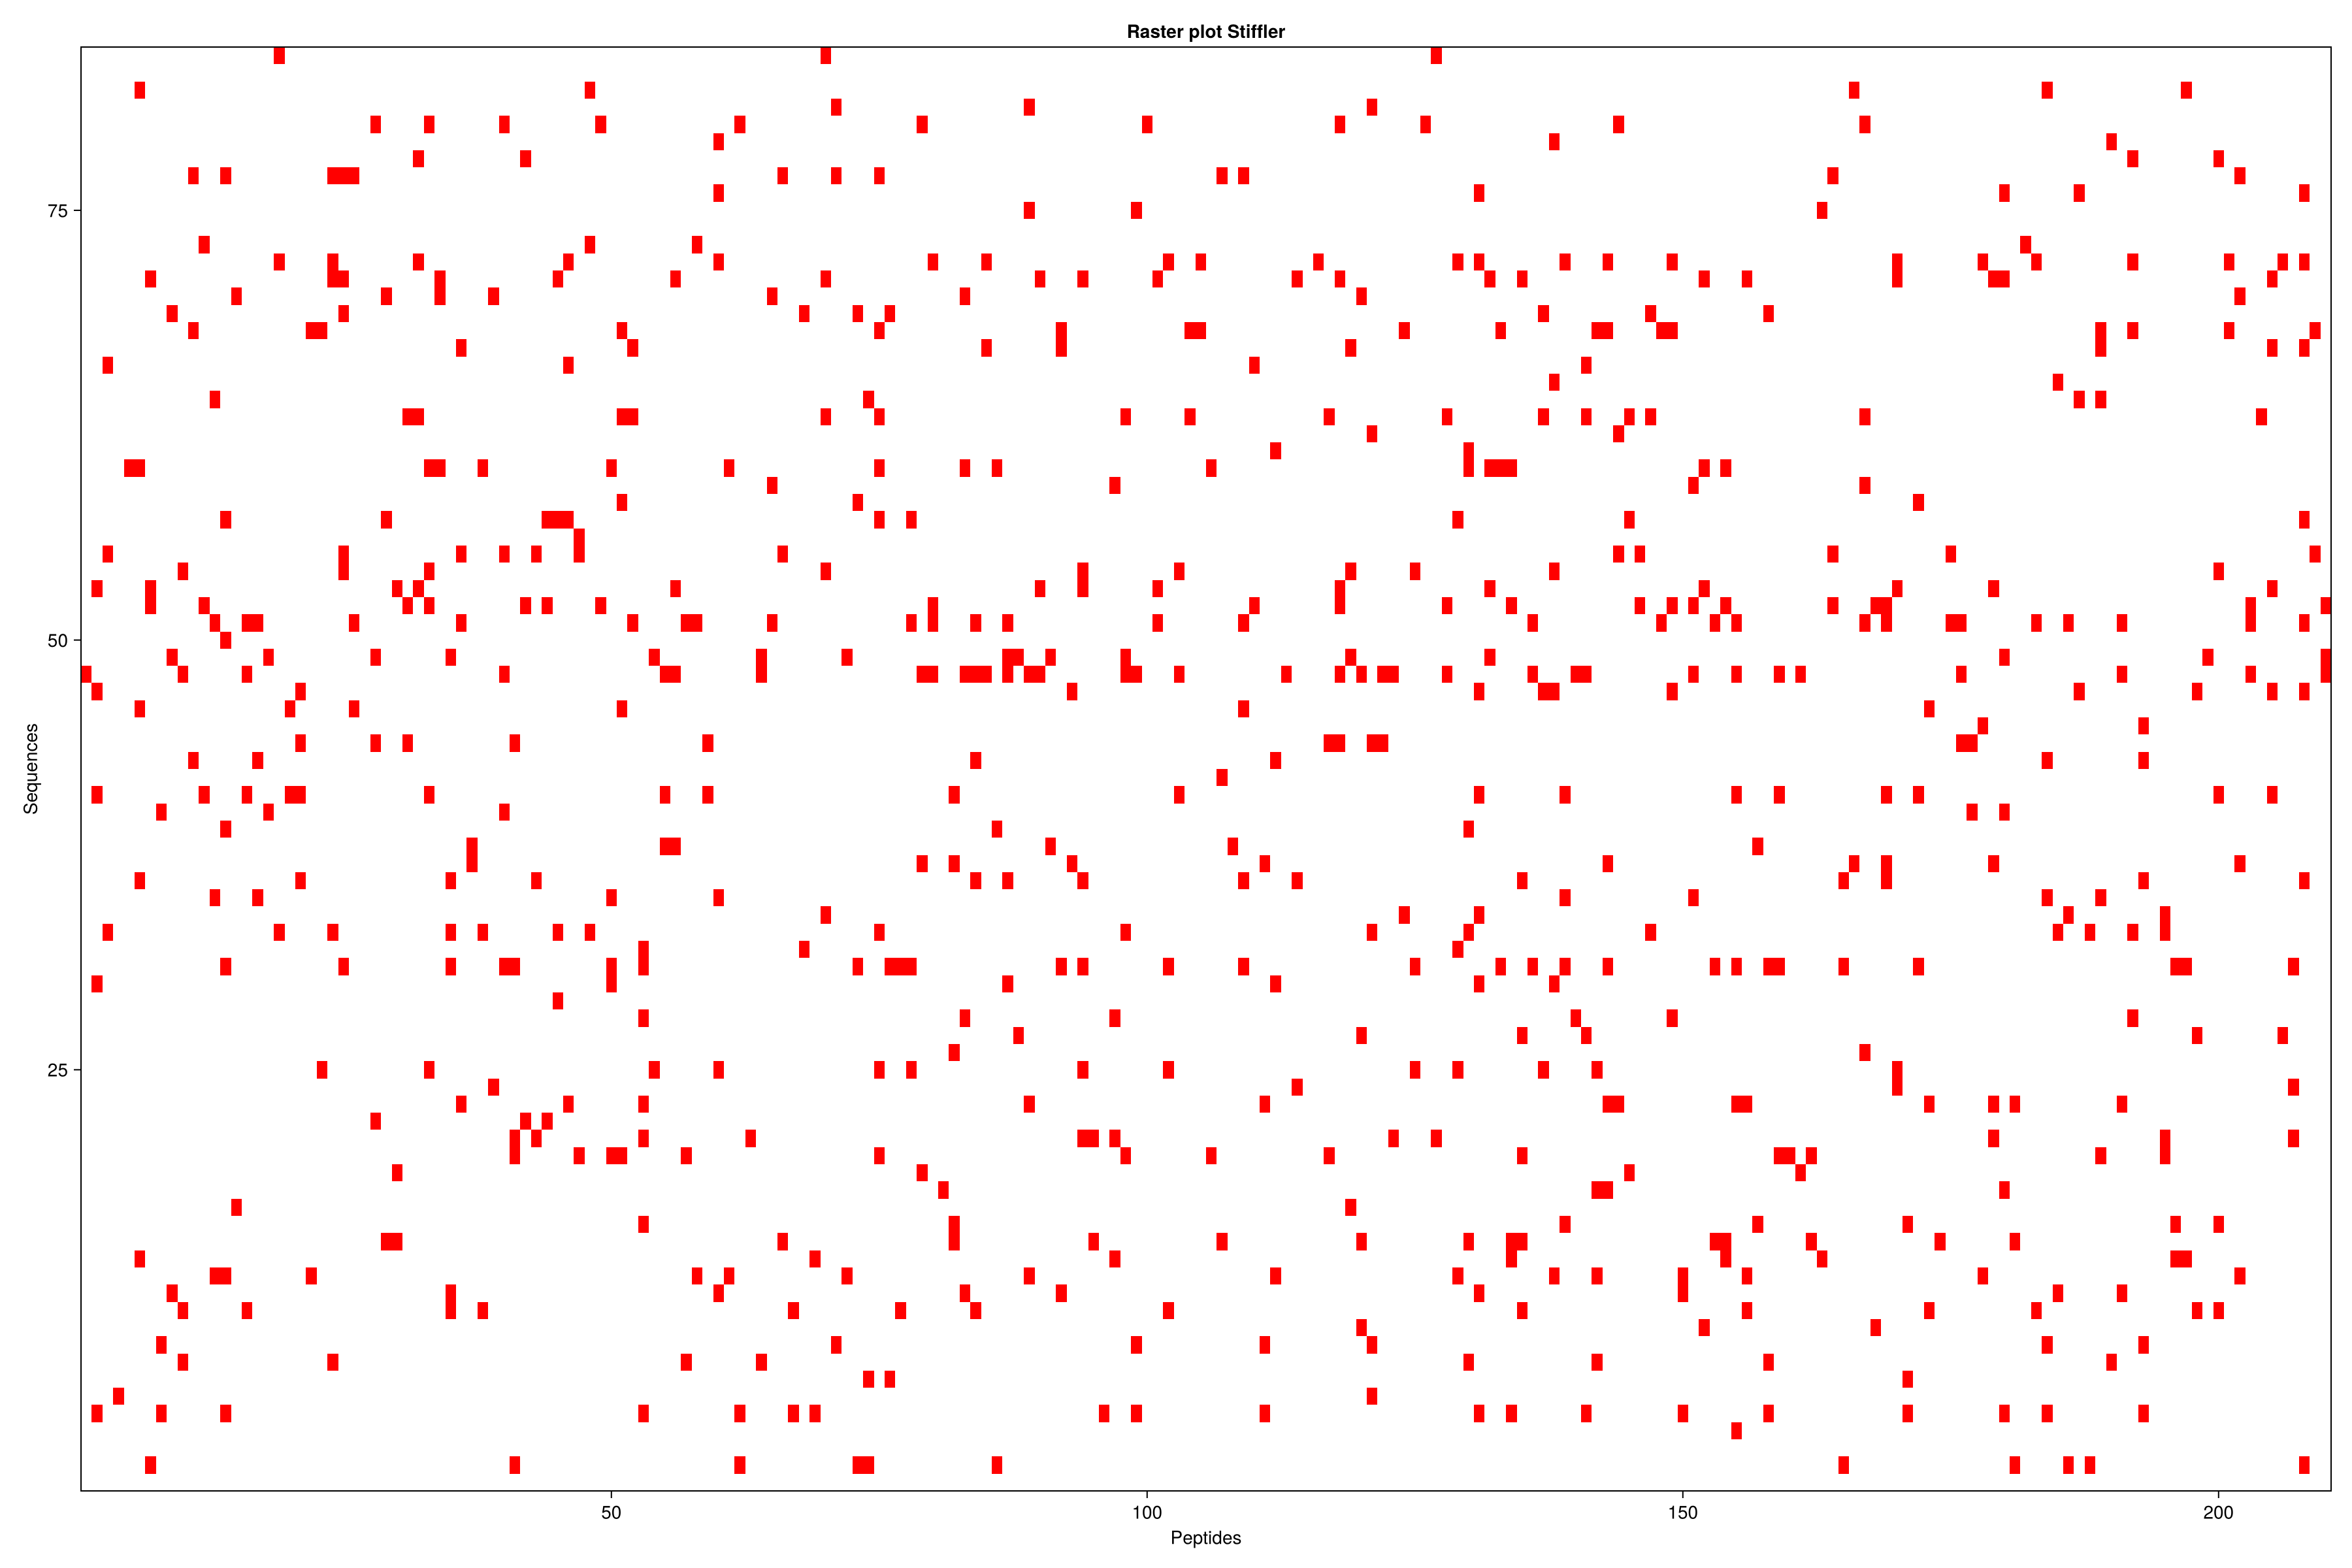

In [6]:
function build_label_matrix(data::Dict{String, <:NamedTuple})
    keys_sorted = collect(keys(data))
    n_strings   = length(keys_sorted)

    # Collect all unique peptides across all sequences
    all_peptides = Set{String}()
    for key in keys_sorted
        union!(all_peptides, data[key].elements)
    end
    
    peptides_sorted = sort(collect(all_peptides))
    n_peptides = length(peptides_sorted)
    
    # Create peptide index lookup
    peptide_to_idx = Dict(pep => i for (i, pep) in enumerate(peptides_sorted))

    M = fill(-1, n_strings, n_peptides)  # Initialize with -1 for padding

    for (i, key) in enumerate(keys_sorted)
        elements = data[key].elements
        labels = data[key].labels
        
        for (elem, label) in zip(elements, labels)
            j = peptide_to_idx[elem]
            M[i, j] = label
        end
    end

    return M, keys_sorted, peptides_sorted
end

function plot_label_matrix(data::Dict{String, <:NamedTuple}, title::String="")
    M, keys_sorted, peptides_sorted = build_label_matrix(data)

    fig = Figure(resolution = (1800, 1200))
    ax  = Axis(
        fig[1, 1],
        title = title,
        xlabel = "Peptides",
        ylabel = "Sequences"
    )

    heatmap!(
        ax,
        M';
        colormap = [:lightgray, :white, :red],
        colorrange = (-1, 1)
    )

    fig
end
plot_label_matrix(data_Stiffler,"Raster plot Stiffler")

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


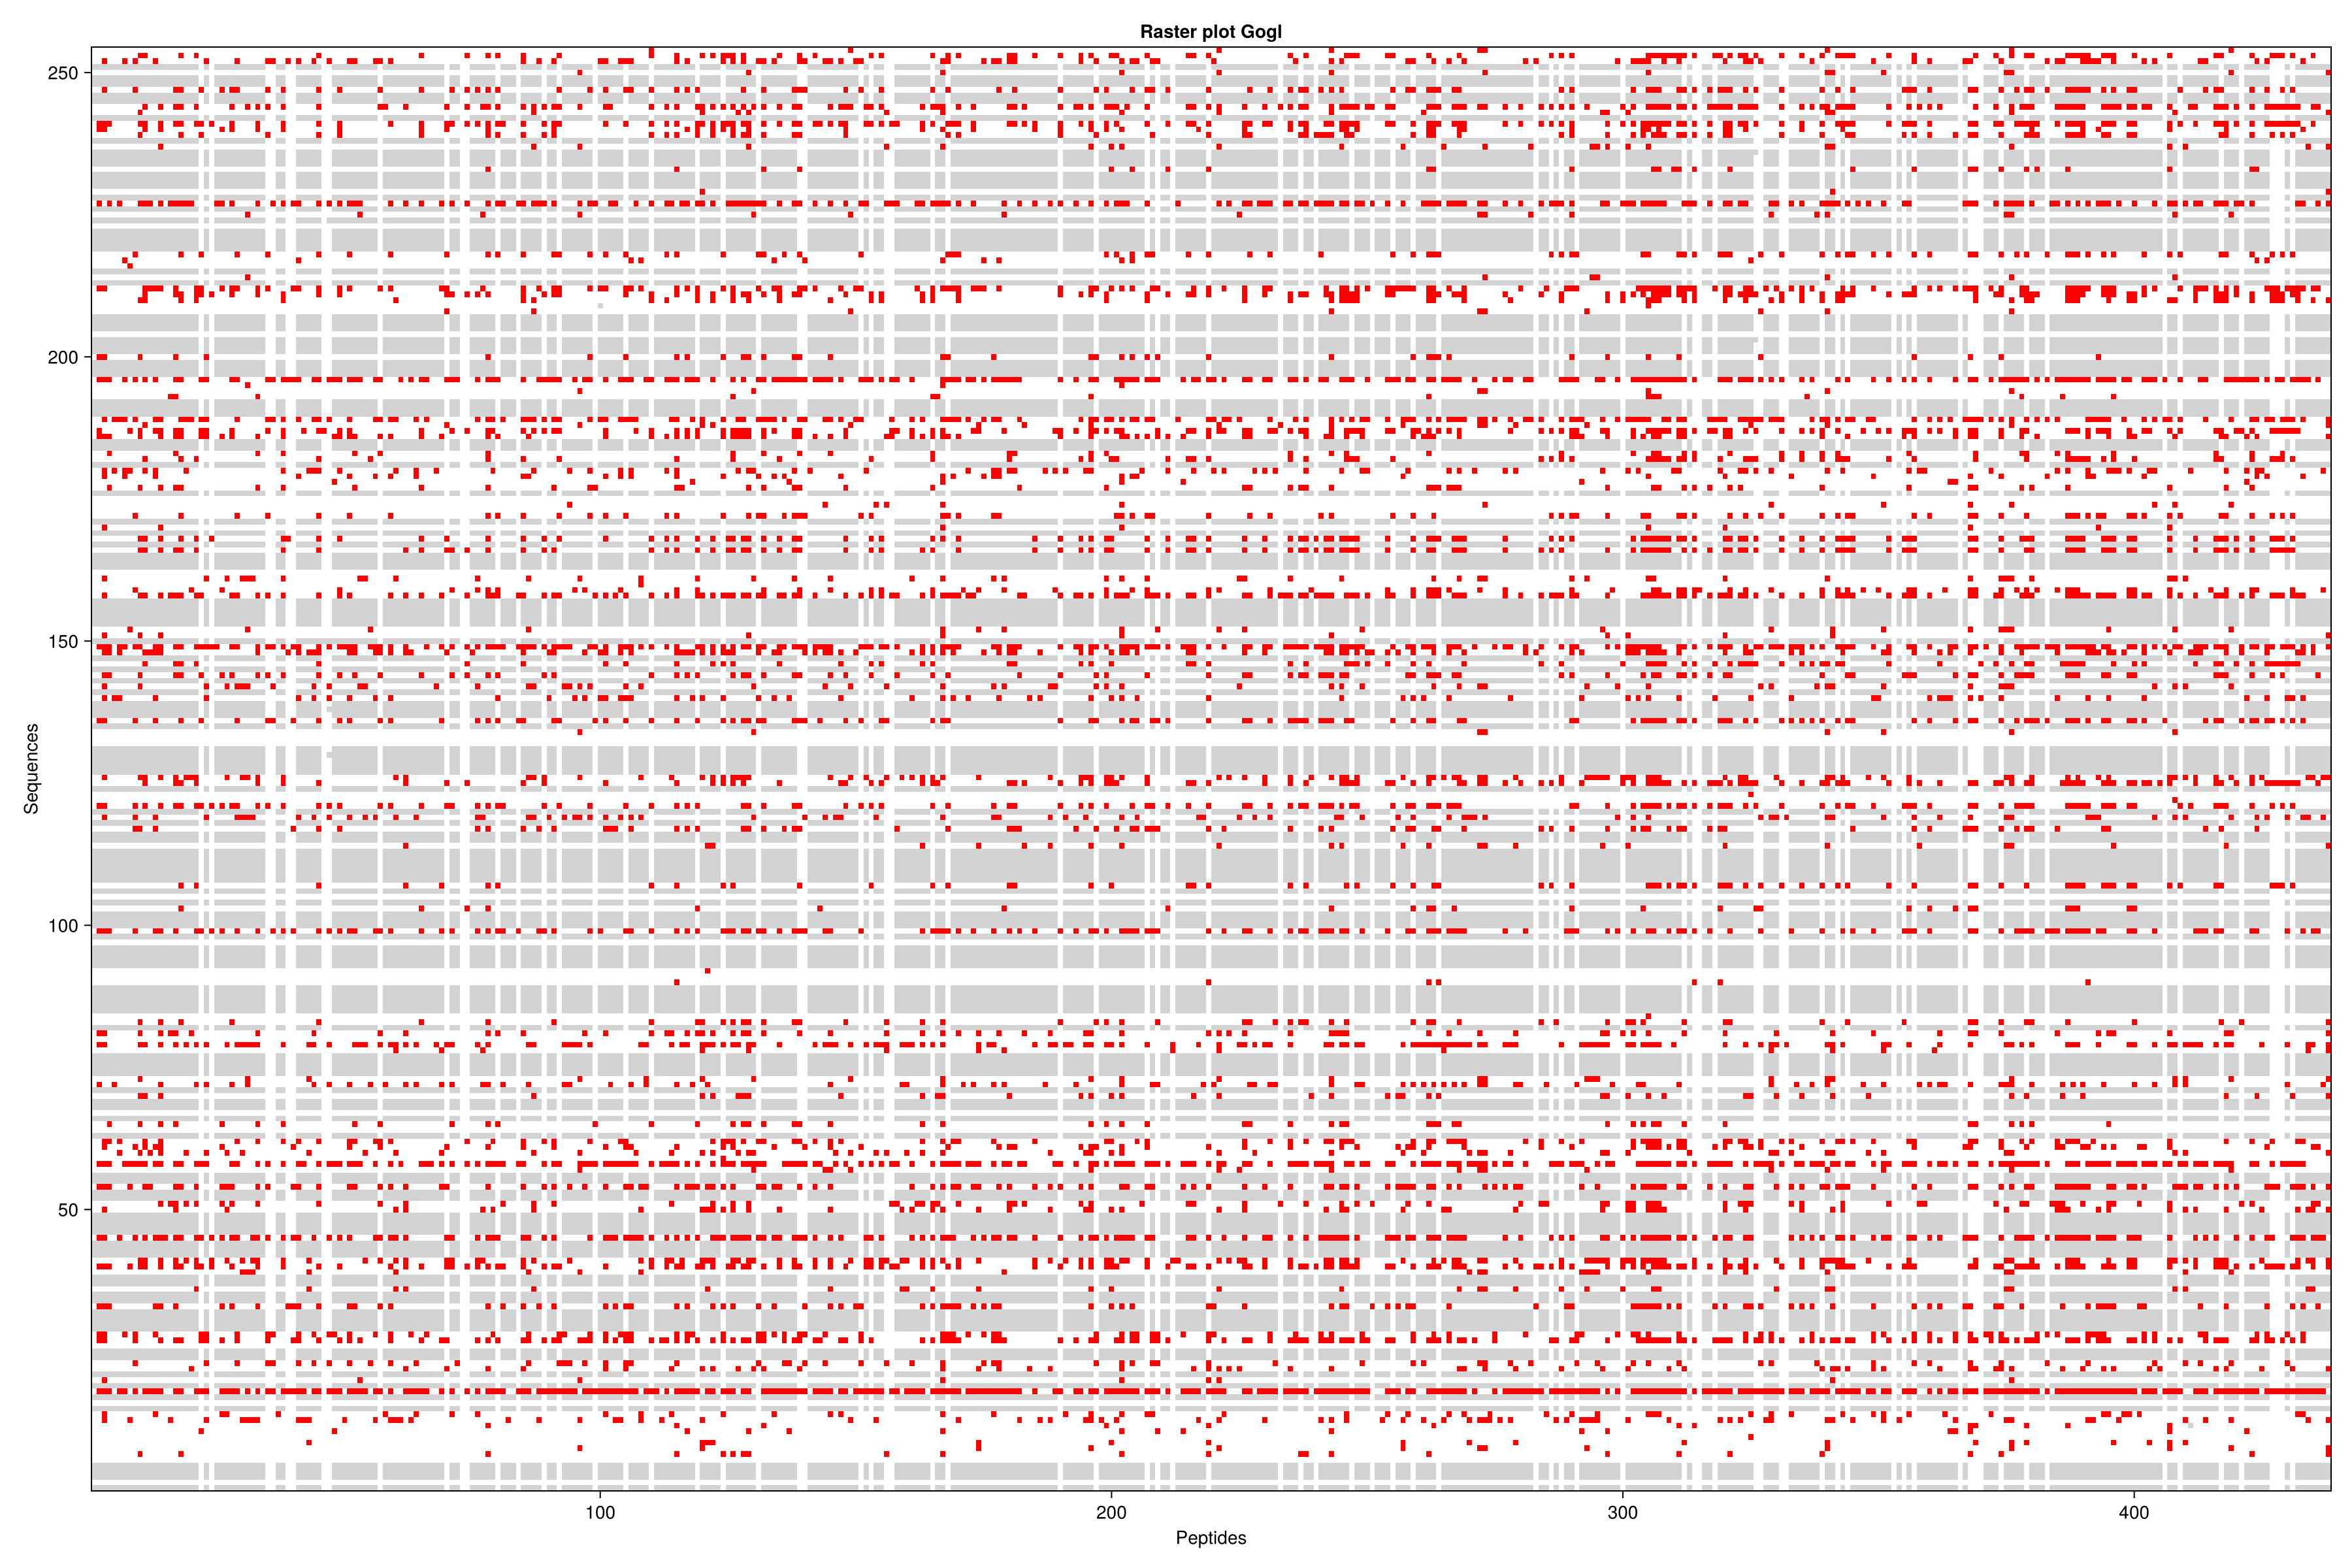

In [7]:
plot_label_matrix(data_Gogl, "Raster plot Gogl")

In [12]:
Q_interaction_centered = Q_inter_centered(onehot, split_idx, labels)
n_singular_vectors = size(V_matrix, 2)
M = Q_interaction_centered * V_matrix
q_left_centered = reshape(M, length_alphabet, split_idx, n_singular_vectors)

21×81×5 Array{Float32, 3}:
[:, :, 1] =
  0.0           0.0           0.00130979   …  -0.000778508   0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.000140229      0.0           0.0
 -5.68357f-5    0.0           0.000841453      0.0          -0.000657215
  0.0           0.0          -1.16917f-6       0.0           0.0
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0           0.000130696      0.0           0.0
  0.0          -0.00258868    0.000194547      0.00168374    0.0
  0.0           0.0          -0.000258969      0.0           0.000115728
  0.0           0.000460411  -0.000334421     -5.29612f-5   -0.00048036
  0.0          -1.7567f-5     0.0          …   0.0           0.000440082
  0.0           0.0          -0.00031444       0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.00131381    0.0           0.000132089      0.0          -0.000549992
  0.0       

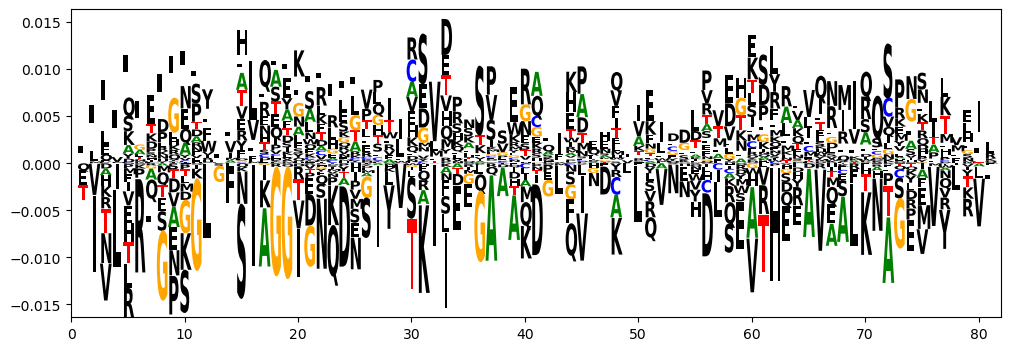

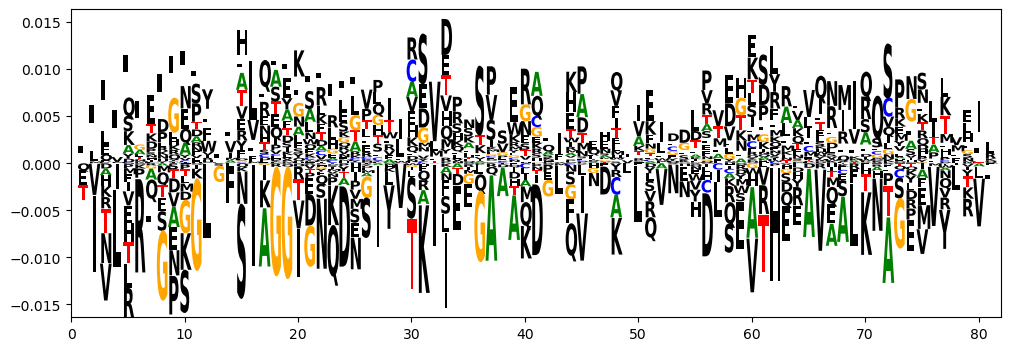

In [30]:
using SequenceLogos
using PyPlot

function plot_matrix_logo(
    matrix::AbstractMatrix,
    alphabet::AbstractVector;
    figsize::Tuple{Real,Real} = (10, 4),
    colorscheme::Symbol = :default,
    custom_colors::Dict = Dict(),
    kwargs...
)
    n_symbols, n_positions = size(matrix)
    
    if length(alphabet) != n_symbols
        throw(ArgumentError("Alphabet length ($(length(alphabet))) must match number of rows in matrix ($n_symbols)"))
    end
    
    # Define color schemes
    # Amino acid colors based on chemical properties
    aminoacid_colors = Dict(
        'A' => "orange",      # Aliphatic/hydrophobic
        'V' => "orange",
        'L' => "orange",
        'I' => "orange",
        'M' => "orange",
        'F' => "green",       # Aromatic
        'Y' => "green",
        'W' => "green",
        'H' => "cyan",        # Positive charge
        'K' => "cyan",
        'R' => "cyan",
        'D' => "red",         # Negative charge
        'E' => "red",
        'S' => "purple",      # Polar
        'T' => "purple",
        'N' => "purple",
        'Q' => "purple",
        'C' => "pink",        # Special
        'G' => "gray",
        'P' => "magenta"
    )
    
    # Nucleotide colors (standard)
    nucleotide_colors = Dict(
        'A' => "green",
        'C' => "blue",
        'G' => "orange",
        'T' => "red",
        'U' => "red"
    )
    
    # Select color mapping based on colorscheme
    if colorscheme == :aminoacid
        color_map = aminoacid_colors
    elseif colorscheme == :nucleotide
        color_map = nucleotide_colors
    elseif colorscheme == :custom
        color_map = custom_colors
    else
        color_map = Dict()  # Use default SequenceLogos colors
    end
    
    # Convert matrix to SequenceLogo format
    # Each column in the matrix represents a position in the logo
    # Each row represents a symbol's weight at that position
    logo_sites = []
    
    for pos in 1:n_positions
        # For each position, create a list of WeightedLetter objects
        letters = []
        for (symbol_idx, symbol) in enumerate(alphabet)
            weight = Float64(matrix[symbol_idx, pos])  # Convert to Float64
            # Convert to Char if it's a String
            letter = symbol isa AbstractString ? first(symbol) : symbol
            
            # Create WeightedLetter (only accepts Char and Float64, no color parameter)
            push!(letters, SequenceLogos.WeightedLetter(letter, weight))
        end
        # Create SequenceLogoSite
        push!(logo_sites, SequenceLogos.SequenceLogoSite(letters))
    end
    
    # Create the SequenceLogo
    logo = SequenceLogos.SequenceLogo(logo_sites)
    
    # Create a new figure with specified size
    PyPlot.figure(figsize=figsize)
    
    # Plot using plot_sequence_logo_nt
    result = SequenceLogos.plot_sequence_logo_nt(logo; kwargs...)
    
    # Apply custom colors if specified
    if !isempty(color_map)
        # Get current axes and modify text colors
        ax = PyPlot.gca()
        for child in ax.get_children()
            try
                text_content = child.get_text()
                if !isnothing(text_content) && length(text_content) == 1
                    letter = text_content[1]
                    if haskey(color_map, letter)
                        child.set_color(color_map[letter])
                    end
                end
            catch
                # Skip objects that don't have get_text method
                continue
            end
        end
    end
    
    return PyPlot.gcf()
end

plot_matrix_logo(q_left_centered[:, :, 4], alphabet; figsize=(12,4), colorscheme=:aminoacid)

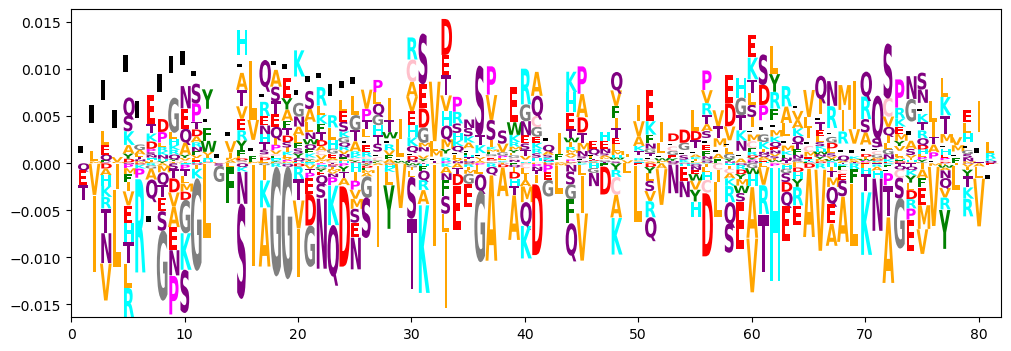

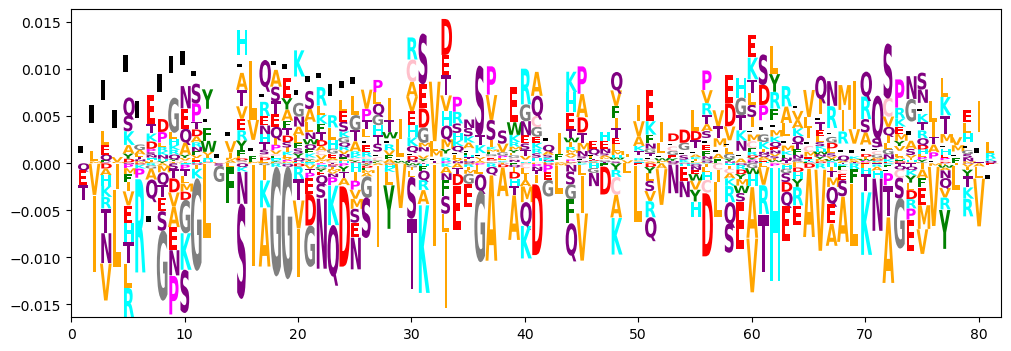

: 

In [ ]:
using SequenceLogos
using PyPlot

function make_colorfun(colorscheme::Symbol, custom_colors::Dict{Char,Any})

    aminoacid_colors = Dict(
        'A' => "orange", 'V' => "orange", 'L' => "orange",
        'I' => "orange", 'M' => "orange",
        'F' => "green",  'Y' => "green",  'W' => "green",
        'H' => "cyan",   'K' => "cyan",   'R' => "cyan",
        'D' => "red",    'E' => "red",
        'S' => "purple", 'T' => "purple",
        'N' => "purple", 'Q' => "purple",
        'C' => "pink",
        'G' => "gray",
        'P' => "magenta"
    )

    nucleotide_colors = Dict(
        'A' => "green",
        'C' => "blue",
        'G' => "orange",
        'T' => "red",
        'U' => "red"
    )

    cmap =
        colorscheme === :aminoacid  ? aminoacid_colors :
        colorscheme === :nucleotide ? nucleotide_colors :
        colorscheme === :custom     ? custom_colors :
        nothing

    if cmap === nothing
        return nothing
    end

    return c -> get(cmap, c, "black")
end

function plot_matrix_logo(
    matrix::AbstractMatrix,
    alphabet::AbstractVector;
    figsize::Tuple{Real,Real} = (12, 4),
    colorscheme::Symbol = :default,
    custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
    kwargs...
)
    n_symbols, n_positions = size(matrix)

    logo_sites = SequenceLogos.SequenceLogoSite[]

    for pos in 1:n_positions
        letters = SequenceLogos.WeightedLetter[]
        for (i, sym) in enumerate(alphabet)
            letter = sym isa AbstractString ? first(sym) : sym
            push!(letters,
                  SequenceLogos.WeightedLetter(letter, Float64(matrix[i, pos])))
        end
        push!(logo_sites, SequenceLogos.SequenceLogoSite(letters))
    end

    logo = SequenceLogos.SequenceLogo(logo_sites)

    PyPlot.figure(figsize=figsize)

    colorfun = make_colorfun(colorscheme, custom_colors)

    if colorfun === nothing
        SequenceLogos.plot_sequence_logo_nt(logo; kwargs...)
    else
        SequenceLogos.plot_sequence_logo(logo, colorfun; kwargs...)
    end

    return PyPlot.gcf()
end

plot_matrix_logo(q_left_centered[:, :, 4], alphabet; figsize=(12,4), colorscheme=:aminoacid)

HERE WE BUILD THE SECOND ORDER CLASSIFIER THAT WE TRAINED ON ALL THE DATA

In [ ]:
results_Gogl = evaluate_pdz_peptide_classifier(data_Gogl, "pdz_pep_matrices_fast.jld2")

# Access results:
println("Best threshold: ", results_Gogl.threshold)
println("AUC: ", results_Gogl.auc)
println("Accuracy: ", results_Gogl.metrics.accuracy)


PDZ-PEPTIDE CLASSIFIER EVALUATION
Data prepared:
  Total samples: 68442
  Positive samples: 8481
  Negative samples: 59961
  Unique PDZ sequences: 254
  Class balance (proportion of 1's): 0.1239
  U dimensions: (1701, 5)
  V dimensions: (210, 5)

CONFUSION MATRIX

                    Predicted
                 Negative  Positive
              ┌──────────┬──────────┐
Actual Negative│   57862  │    2099  │
              ├──────────┼──────────┤
       Positive│    2099  │    6382  │
              └──────────┴──────────┘

Performance Metrics:
────────────────────────────────────────────────────────────
  Threshold:    0.4044  (FP = FN = 2099)
  Accuracy:     0.9387  (64244 correct out of 68442)
  Precision:    0.7525  (TP / (TP + FP))
  Recall:       0.7525  (TP / (TP + FN))
  Specificity:  0.965  (TN / (TN + FP))
  F1 Score:     0.7525  (harmonic mean of precision/recall)

  AUC-ROC:      0.9694

PREDICTION STATISTICS

  Score range: [-113.4144, 52.7704]
  Prob range:  [0.0, 1.0]
  Mean p

In [25]:
results_Stiffler = evaluate_pdz_peptide_classifier(data_Stiffler, "pdz_pep_matrices_fast.jld2")

# Access results:
println("Best threshold: ", results_Stiffler.threshold)
println("AUC: ", results_Stiffler.auc)
println("Accuracy: ", results_Stiffler.metrics.accuracy)


PDZ-PEPTIDE CLASSIFIER EVALUATION
Data prepared:
  Total samples: 17640
  Positive samples: 706
  Negative samples: 16934
  Unique PDZ sequences: 84
  Class balance (proportion of 1's): 0.04
  U dimensions: (1701, 5)
  V dimensions: (210, 5)

CONFUSION MATRIX

                    Predicted
                 Negative  Positive
              ┌──────────┬──────────┐
Actual Negative│   16411  │     523  │
              ├──────────┼──────────┤
       Positive│     523  │     183  │
              └──────────┴──────────┘

Performance Metrics:
────────────────────────────────────────────────────────────
  Threshold:    0.1849  (FP = FN = 523)
  Accuracy:     0.9407  (16594 correct out of 17640)
  Precision:    0.2592  (TP / (TP + FP))
  Recall:       0.2592  (TP / (TP + FN))
  Specificity:  0.9691  (TN / (TN + FP))
  F1 Score:     0.2592  (harmonic mean of precision/recall)

  AUC-ROC:      0.84

PREDICTION STATISTICS

  Score range: [-99.2099, 2.6889]
  Prob range:  [0.0, 0.9364]
  Mean prob: 

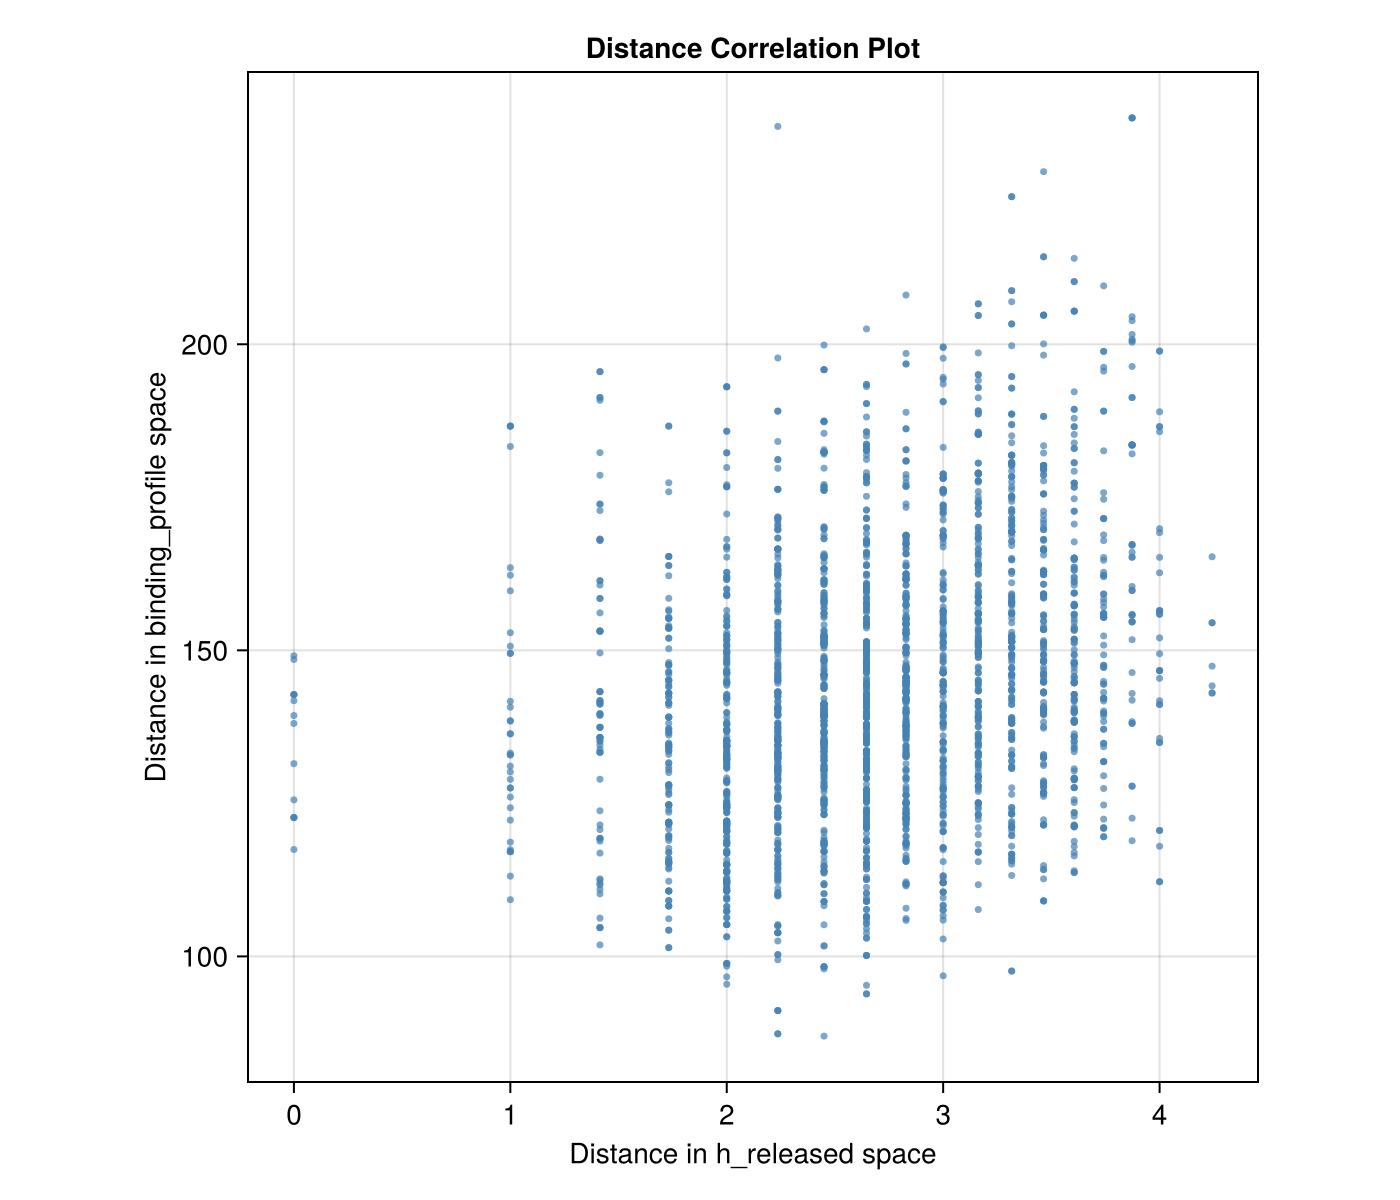

In [6]:
keys_list = sort(collect(keys(data_Gogl)))

h_released = get_released_unit(
    rbm,
    n_release,
    data_Gogl,
    alphabet,
    alphabet_dict;
    keys_list = keys_list
)

binding_profiles = predict_profiles_matrix_by_pdz(
    data_Gogl,
    "pdz_pep_matrices_fast.jld2";
    keys_list = keys_list
)
function sample_pairwise_distances(
    X::AbstractMatrix,   # d₁ × N
    Y::AbstractMatrix,   # d₂ × N
    n_samples::Int;
    seed = 123,
    metric = :euclidean
)
    _, N = size(X)

    rng = MersenneTwister(seed)

    dx = Vector{Float32}(undef, n_samples)
    dy = Vector{Float32}(undef, n_samples)

    for k in 1:n_samples
        i = rand(rng, 1:N)
        j = rand(rng, 1:N)
        while i == j
            j = rand(rng, 1:N)
        end

        xi = @view X[:, i]
        xj = @view X[:, j]

        yi = @view Y[:, i]
        yj = @view Y[:, j]

        dx[k] = metric === :euclidean ? norm(xi .- xj) :
                metric === :cosine   ? 1f0 - dot(xi, xj) / (norm(xi) * norm(xj)) :
                metric === :hamming  ? count(!=, xi, xj) :
                error("Unknown metric")

        dy[k] = norm(yi .- yj)
    end

    return dx, dy
end

num_samples = 30_000
Y = binding_profiles.scores
dist_h, dist_b = sample_pairwise_distances(
    h_released,
    Y,
    num_samples
)


# --- 4. Plotting ---
fig = Figure(size = (700, 600))
ax = Axis(fig[1, 1],
    title = "Distance Correlation Plot",
    xlabel = "Distance in h_released space",
    ylabel = "Distance in binding_profile space",
    aspect = 1 # Square aspect ratio helps see correlation
)

# Scatter plot of distances
scatter!(ax, dist_h, dist_b, 
    markersize = 5, 
    color = (:steelblue, 0.7),
    strokewidth = 0
)

fig

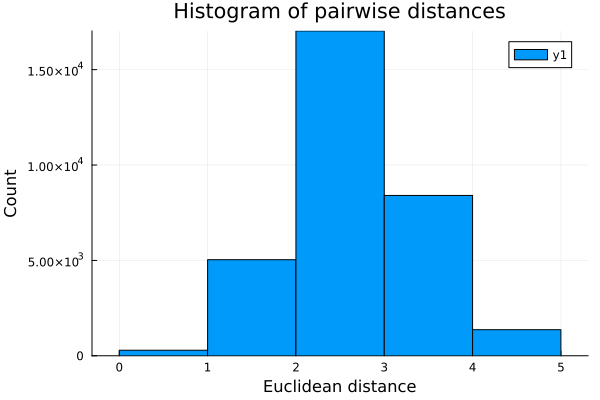

In [10]:
using Distances
using StatsPlots   # or Plots

D = pairwise(Euclidean(), h_released; dims=2)

# Extract upper triangle (unique distances, excluding zeros)
distances = D[triu!(trues(size(D)), 1)]

# Histogram
histogram(distances,
    bins=8,
    xlabel="Euclidean distance",
    ylabel="Count",
    title="Histogram of pairwise distances")


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


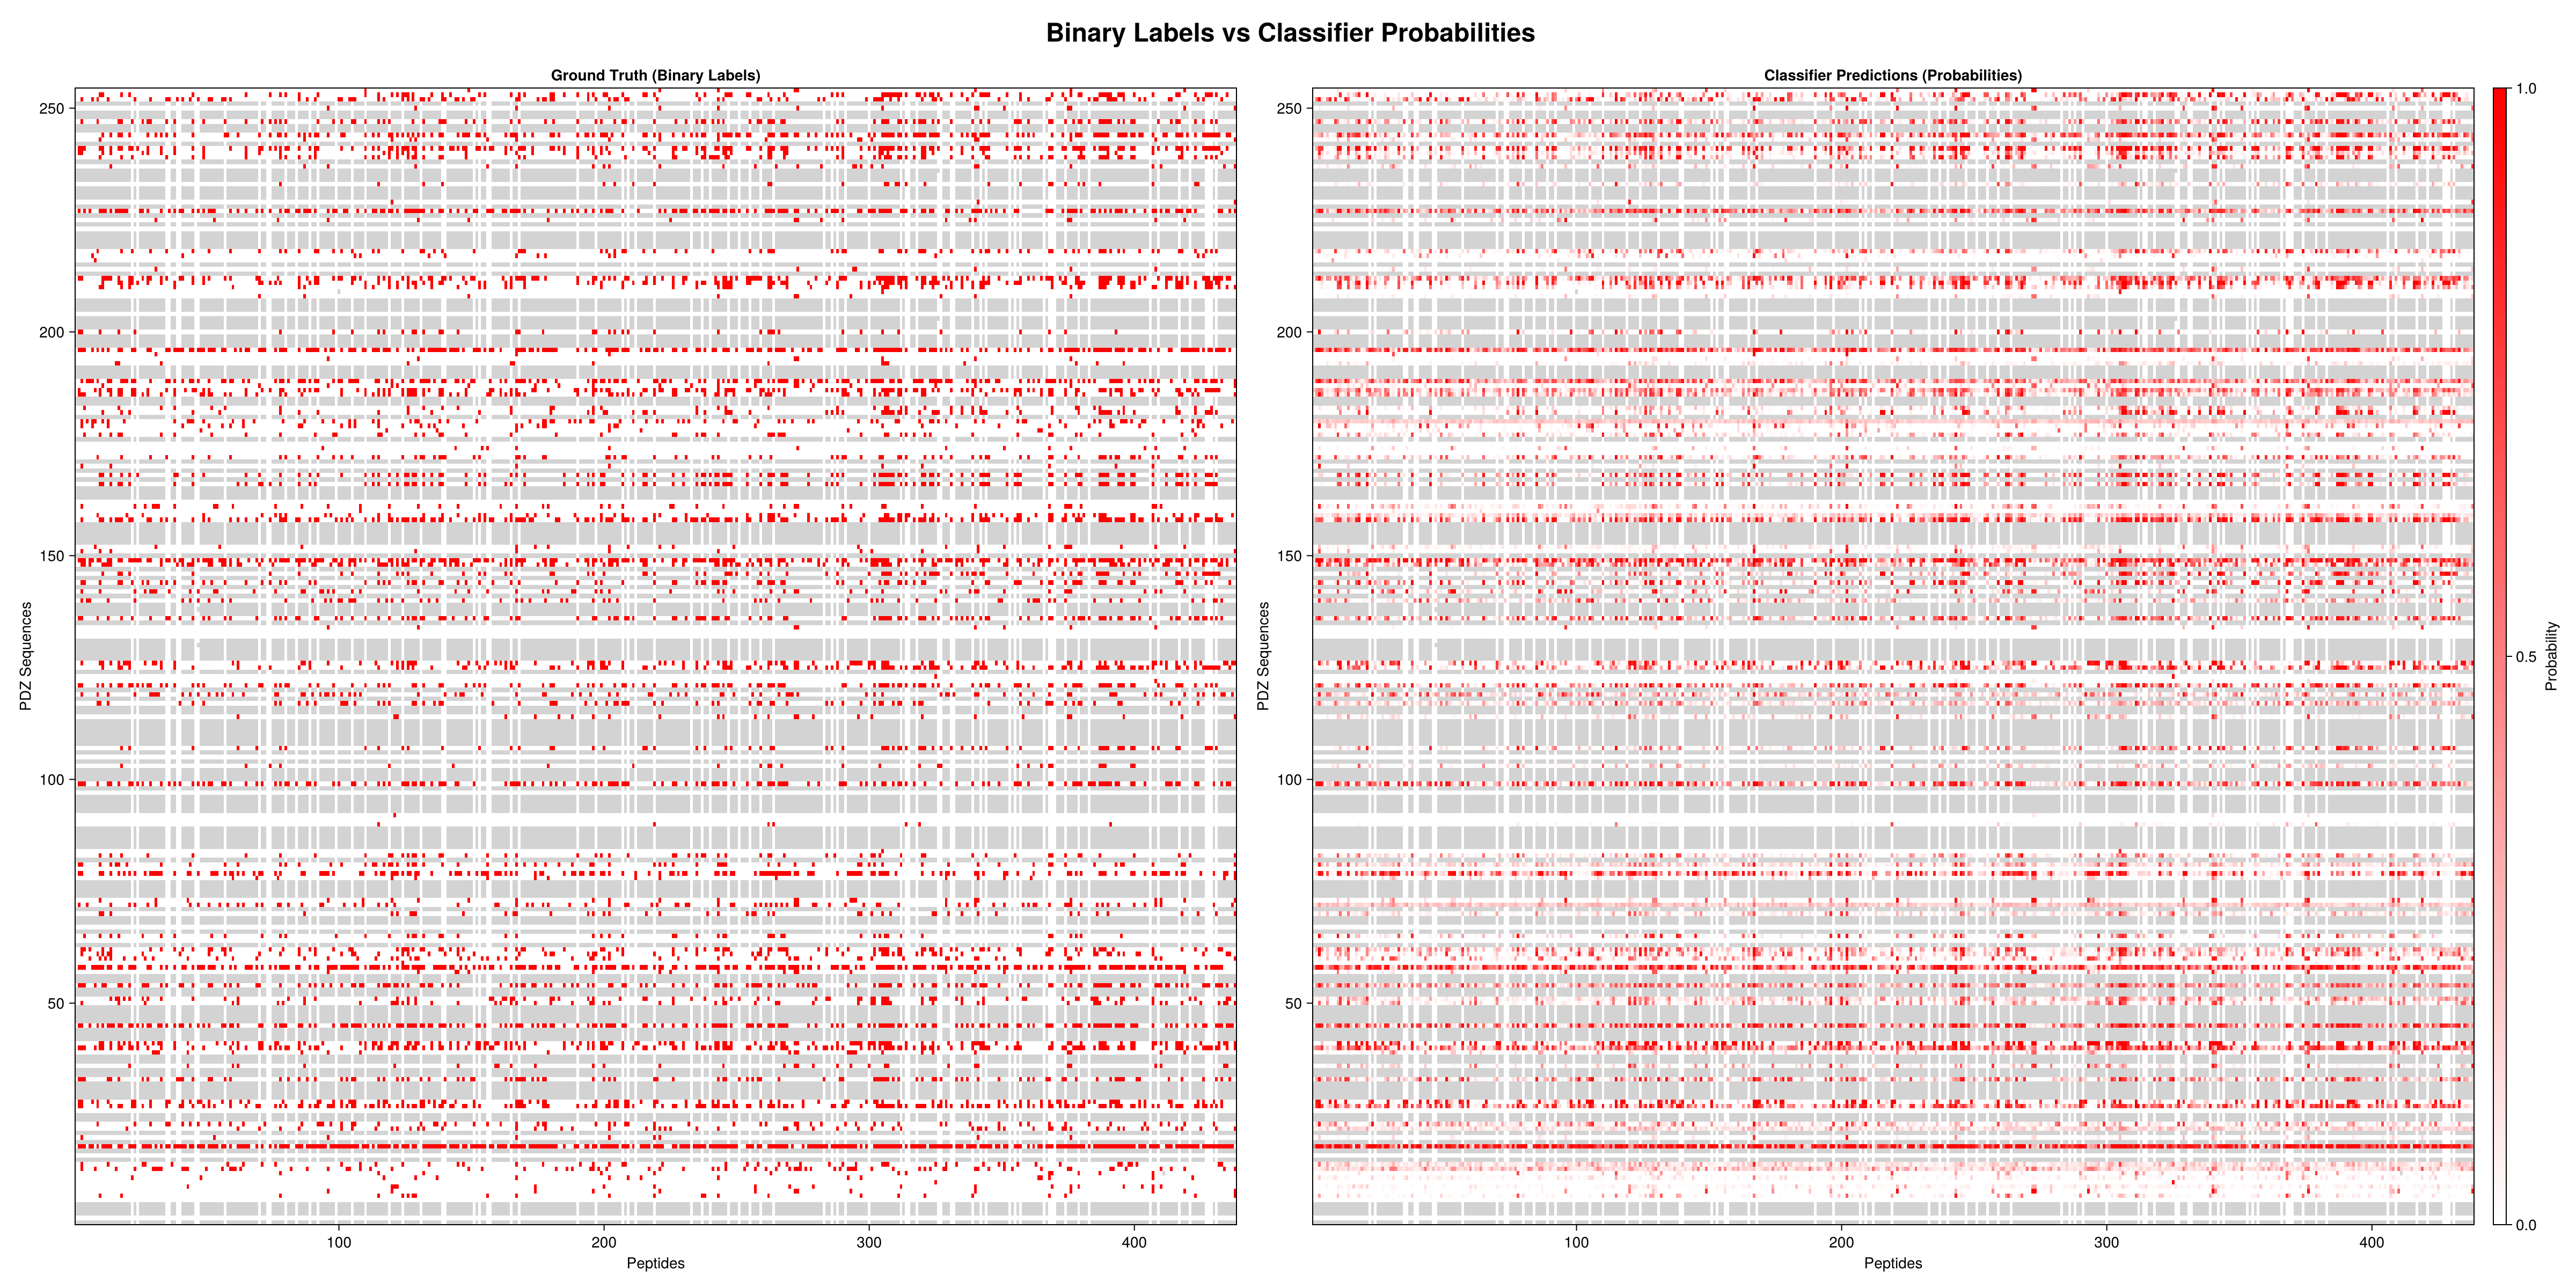

In [ ]:
plot_labels_vs_probabilities(data_Gogl, results_Gogl.probs)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


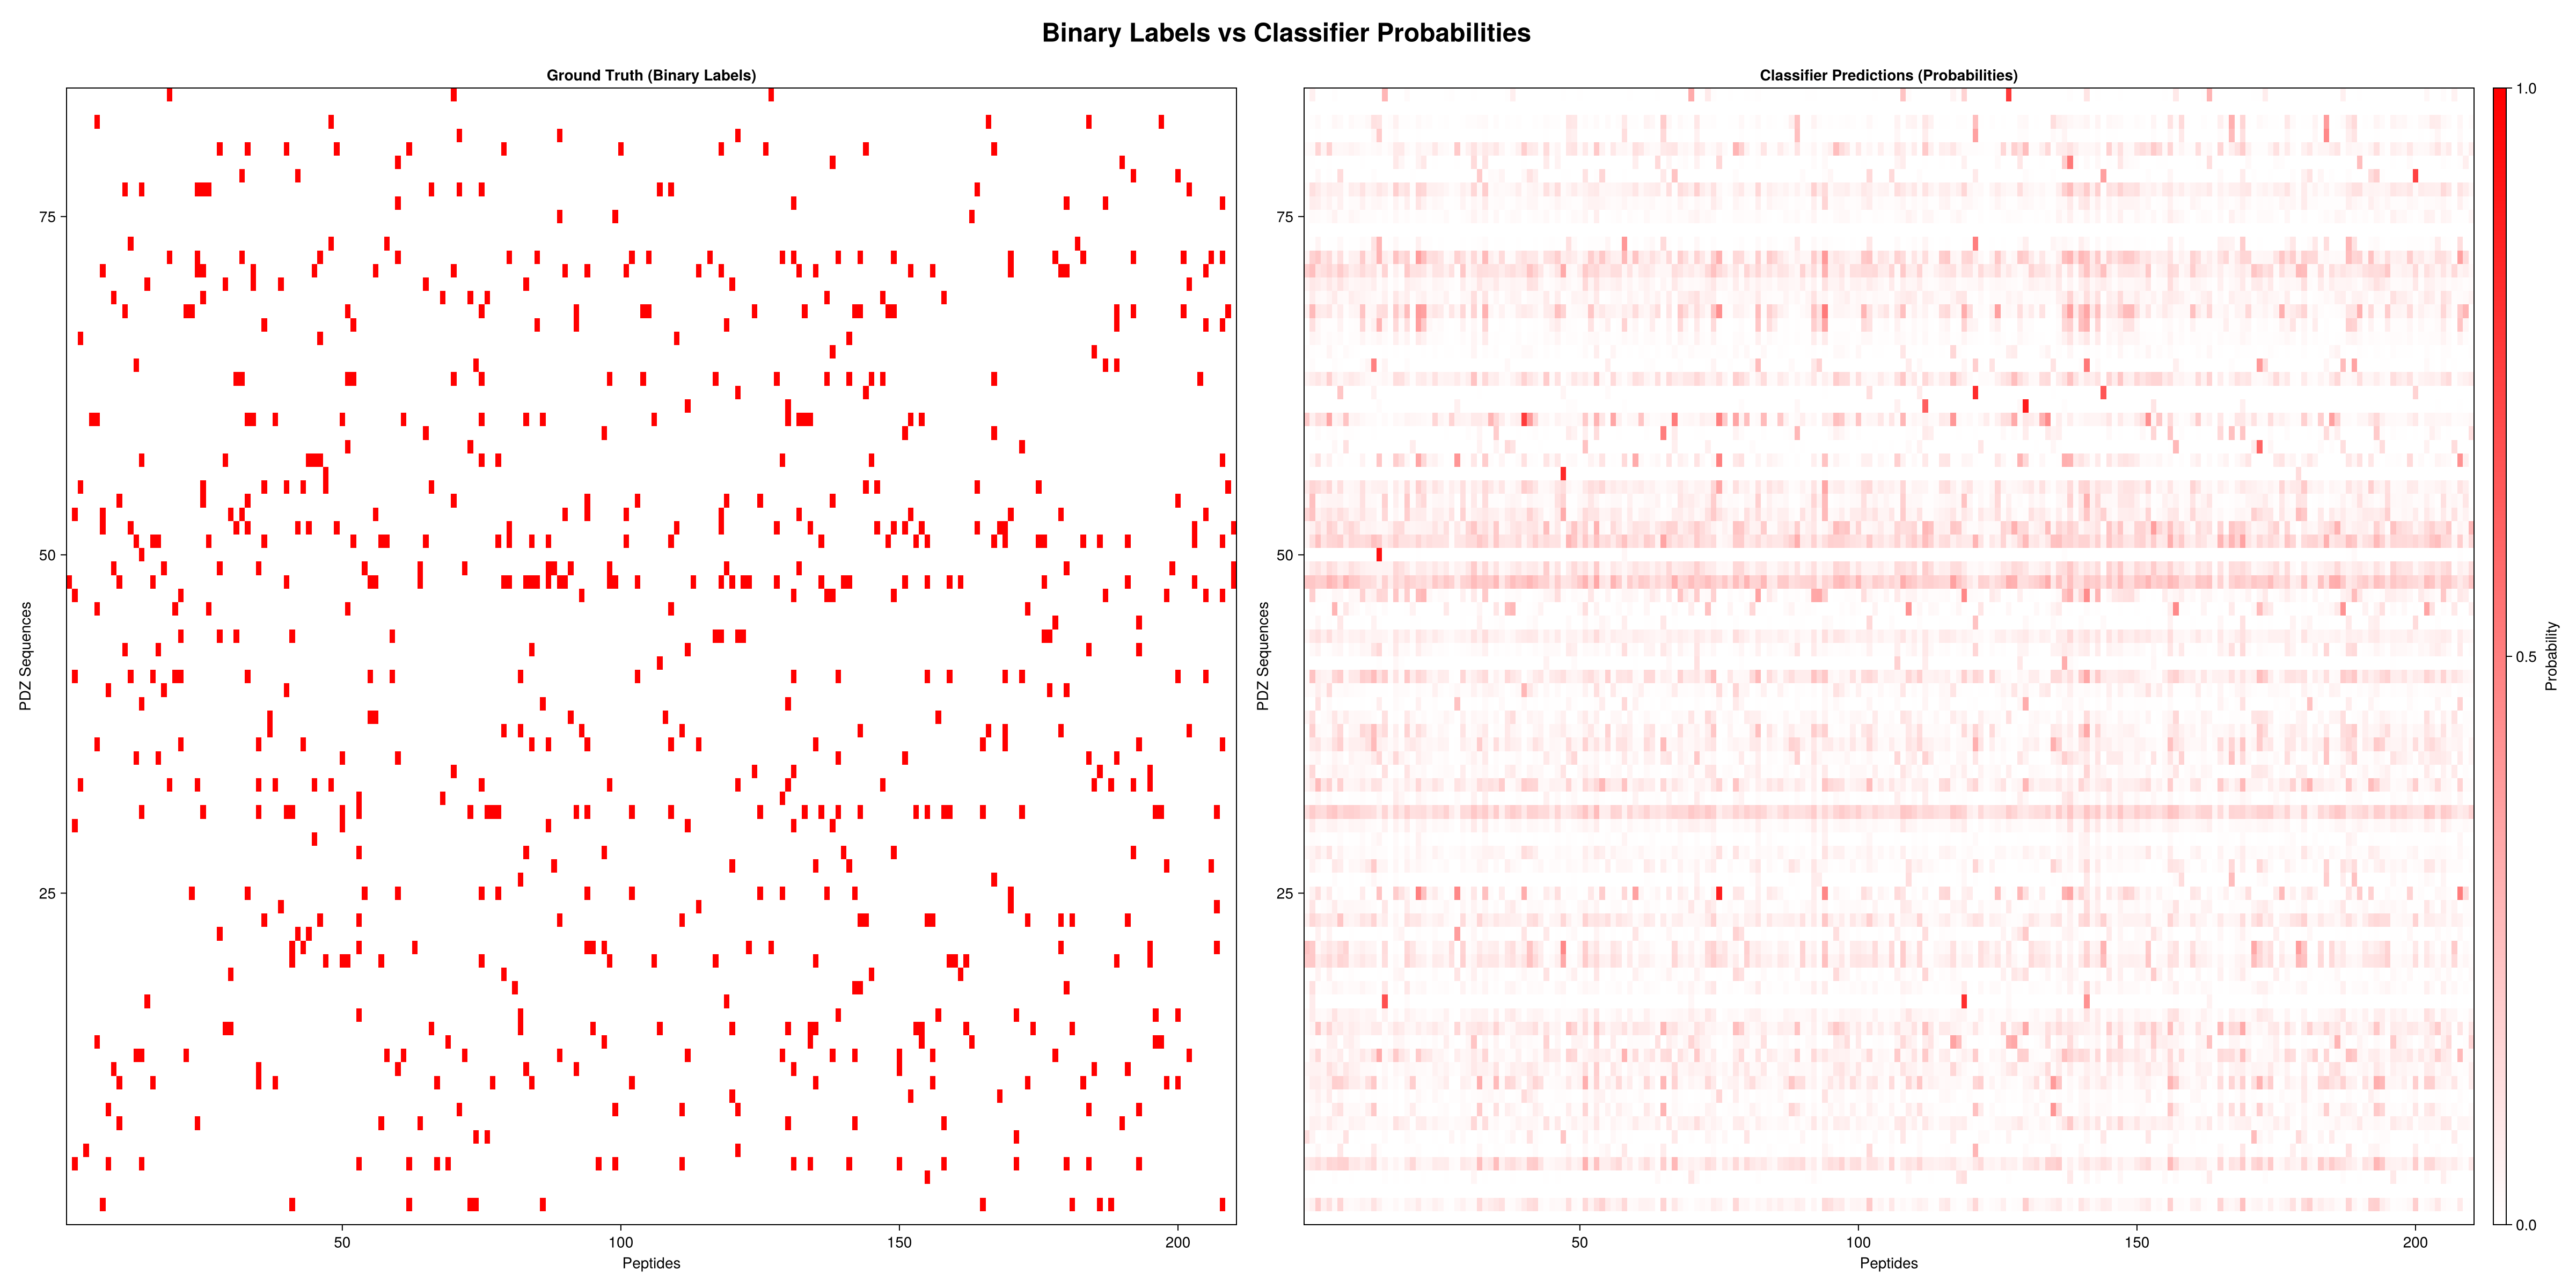

In [27]:
plot_labels_vs_probabilities(data_Stiffler, results_Stiffler.probs)

Now we can try to do the swapping, the first naive idea is to do this, I will look at the free energy of the generated sequence step by step and I will confront the probabilities assigned by the bilinear model and the expected ones.

NOTE HERE YOU HAVE FREEDOM OF CHOOSING THE TWO NUMBERS
I am doing it with Gogl data

Starting Sequence: --IIQK-DQHGFGFTVSGD-----RIVLVQSVRPGGAAMKAGVKEGDRIIKVNGTMVTNSSHLEVVKLIKSGA-YVALT--
Target Sequence:   TVTLNMEKYNFLGISIVGQSNERDGGIYIGSIMKGGAVAADGIEPGDMLLQVNEINFENMSNDDAVRVLRE----------
Number of peptides in target: (448,)


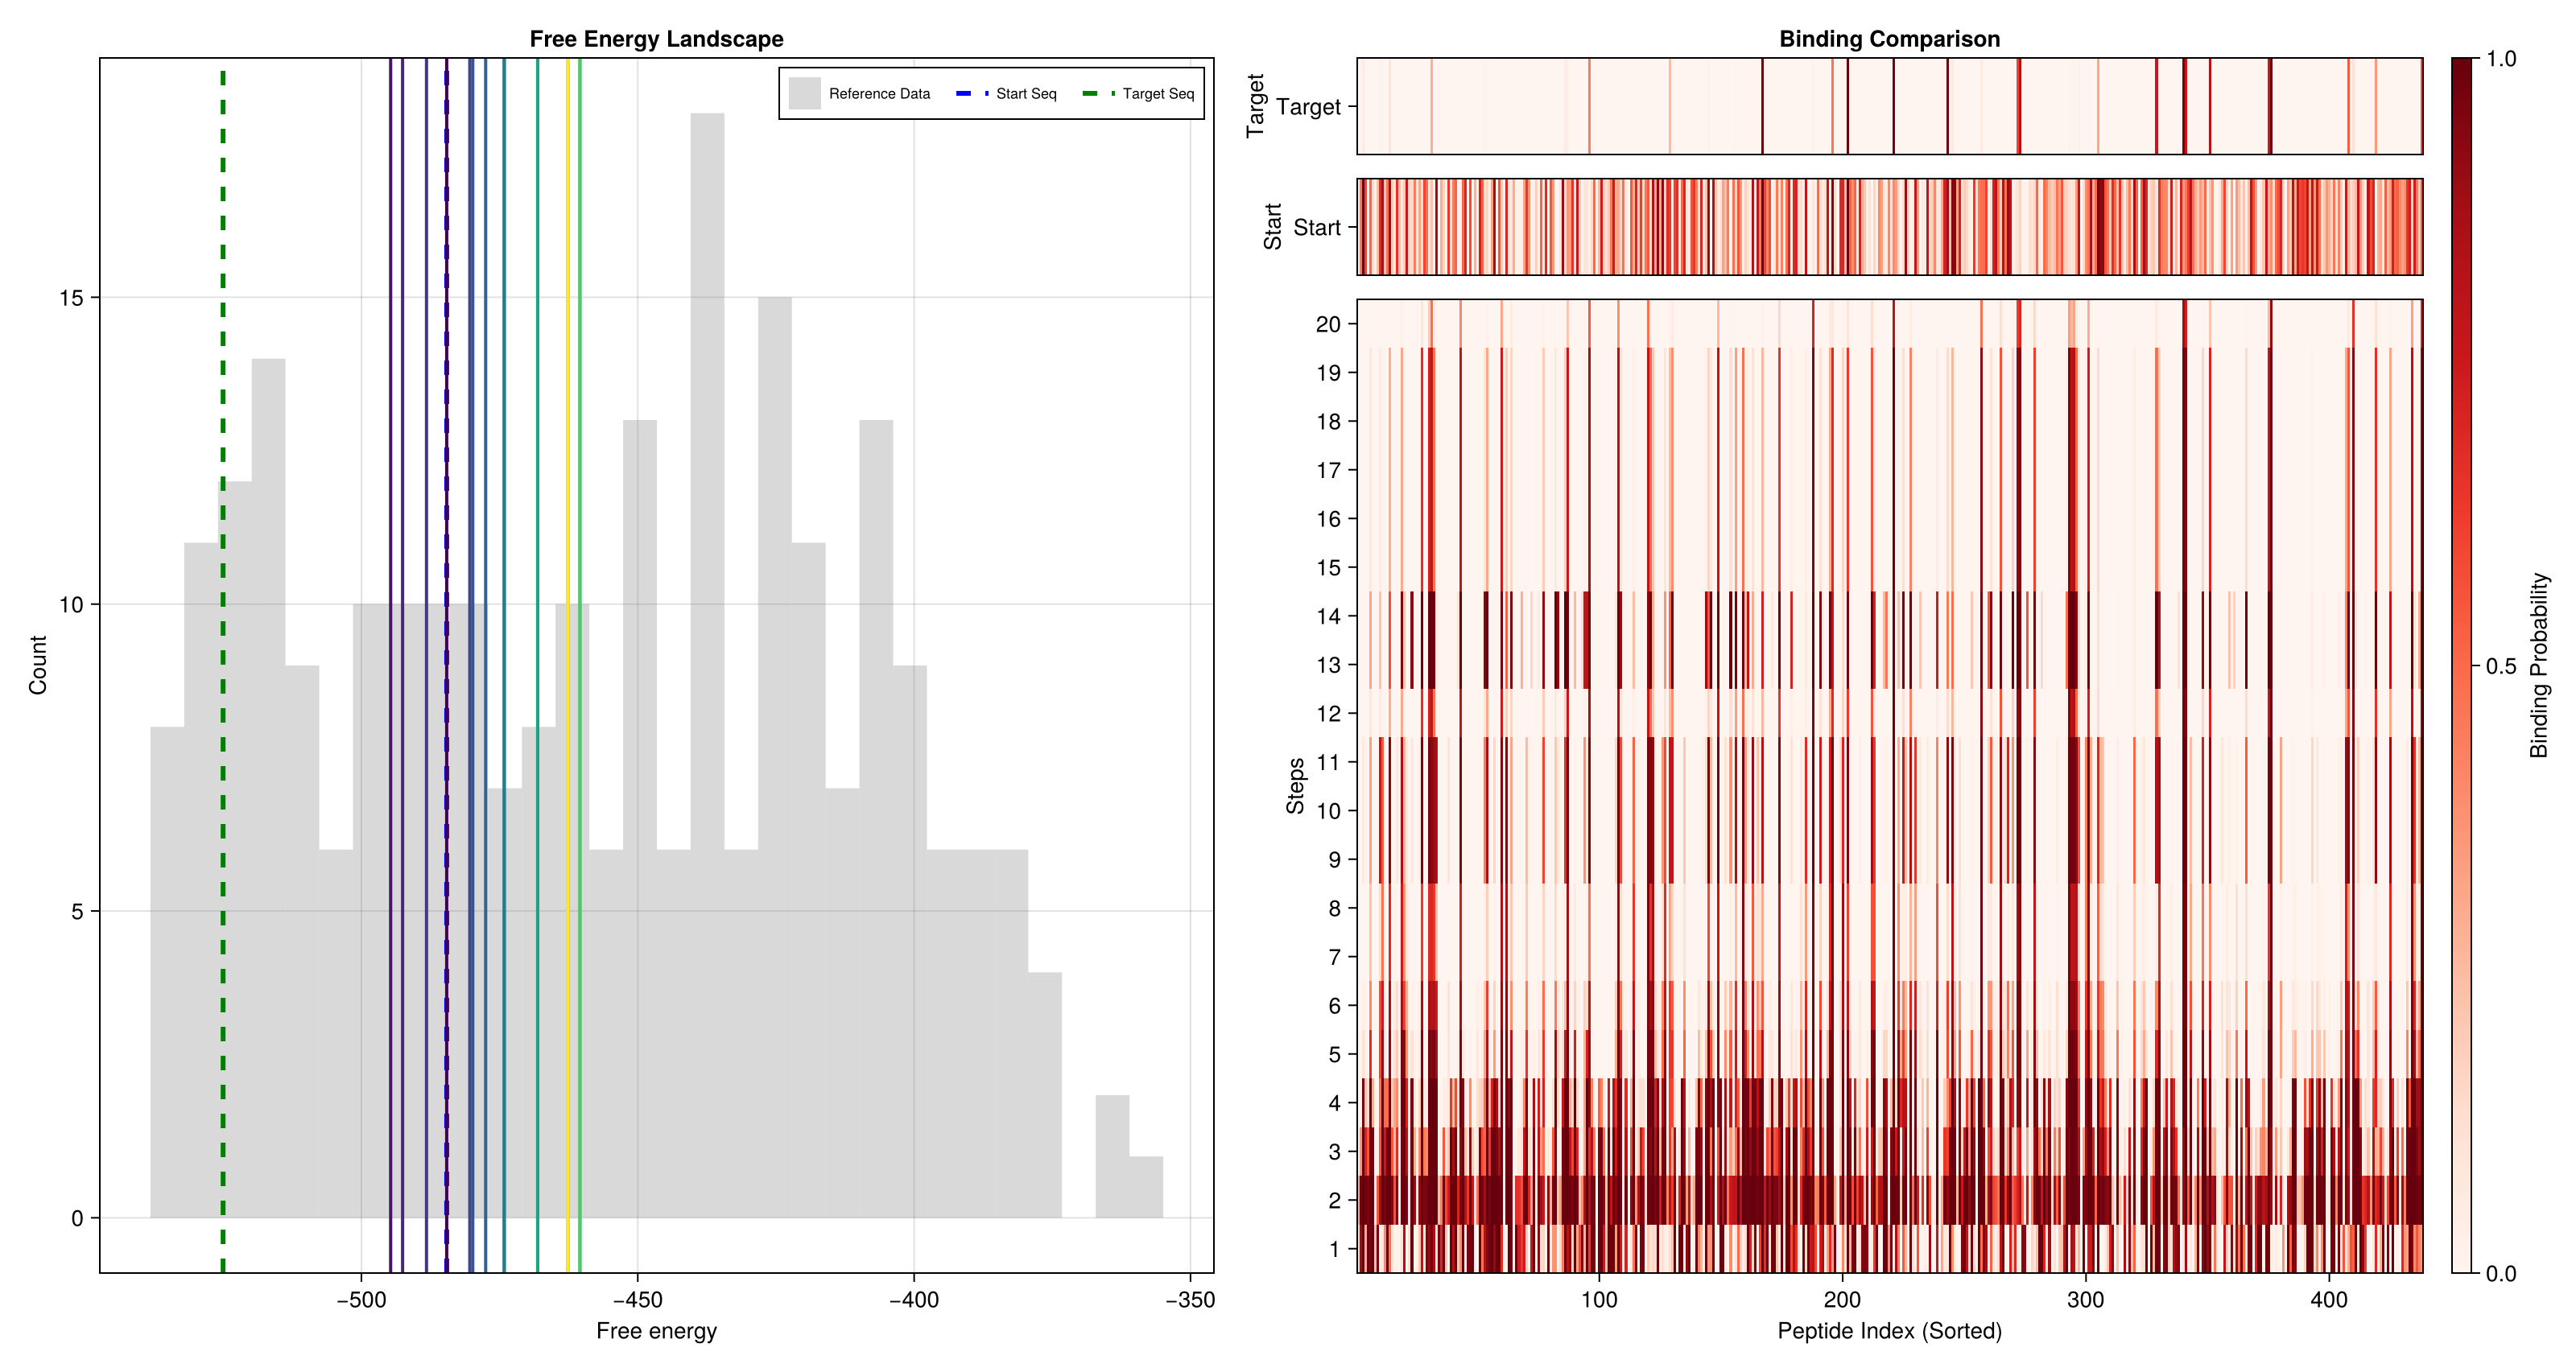

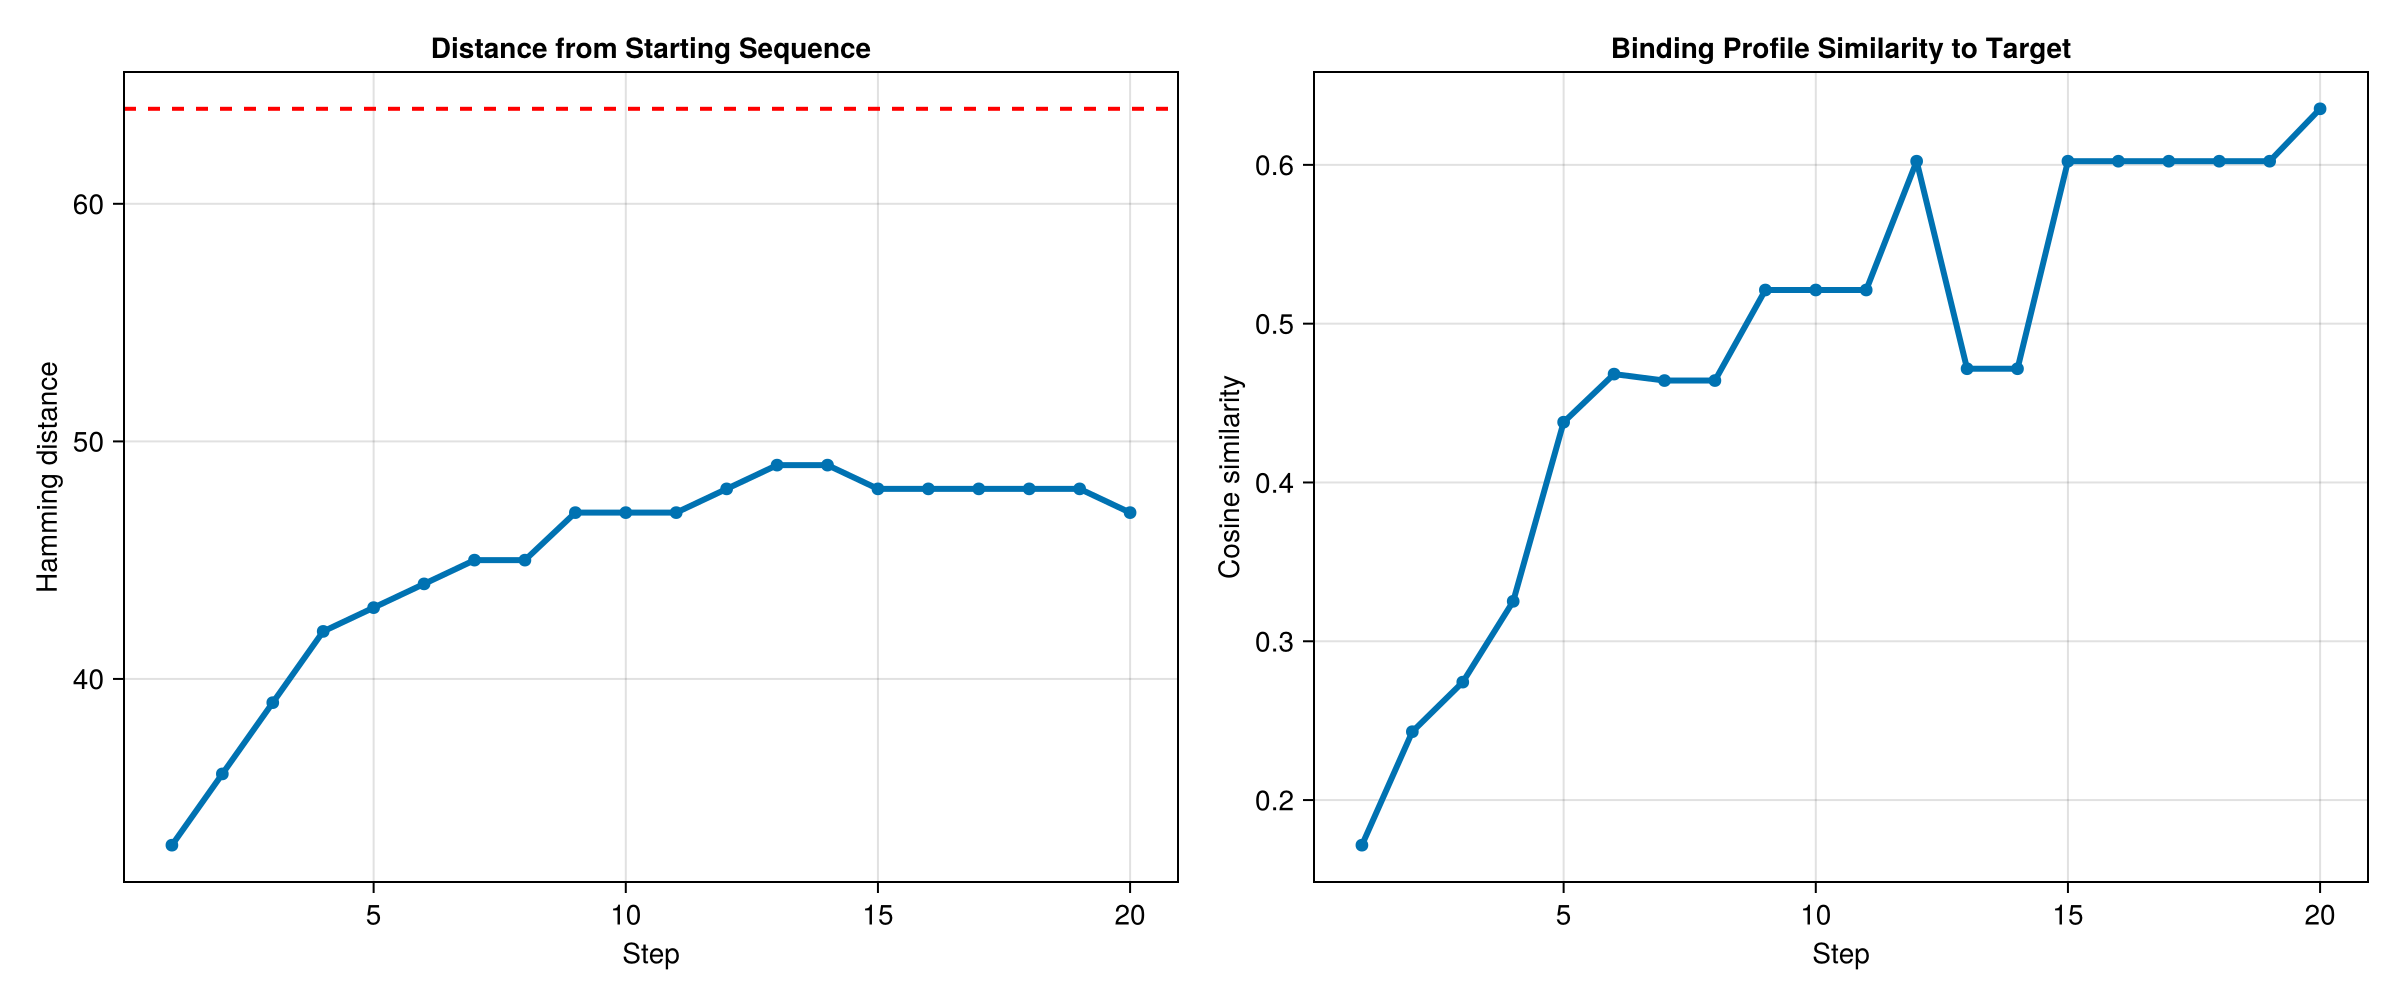

CairoMakie.Screen{IMAGE}


In [62]:
# 1. Configuration
steps = 20
m = 54                          # Index for the starting PDZ
n = 250                           # Index for the target PDZ

# 2. Data Selection
keys_list = collect(keys(data_Gogl))

starting_seq = keys_list[m]     # Start sequence (String)
target_key   = keys_list[n]     # Target sequence name (String)
target_tuple = data_Gogl[target_key] # The NamedTuple containing .elements

# 3. Execution
println("Starting Sequence: ", starting_seq)
println("Target Sequence:   ", target_key)
println("Number of peptides in target: ", size(target_tuple.elements))

fig, fig2 = plot_energy_and_binding_profile(
    rbm,
    data_Gogl,
    alphabet,
    alphabet_dict,
    starting_seq,
    target_key,
    target_tuple,
    n_release,
    steps
)

# Display in your notebook or IDE
display(fig)
display(fig2)

Starting Sequence: --TLKK-SNMGFGFTIIGGDEP-DEFLQVKSVIPDGPAAQDGMETGDVIVYINEVCVLGHTHADVVKLFQS----------
Target Sequence:   -VELER-GPSGLGMGLIDGMHTHAPGLYIQTLLPGSPAAADGLSLGDRILEVNGSSLLGLGYLRAVDLIRHGGKKMRFLV-
Number of peptides in target: (448,)


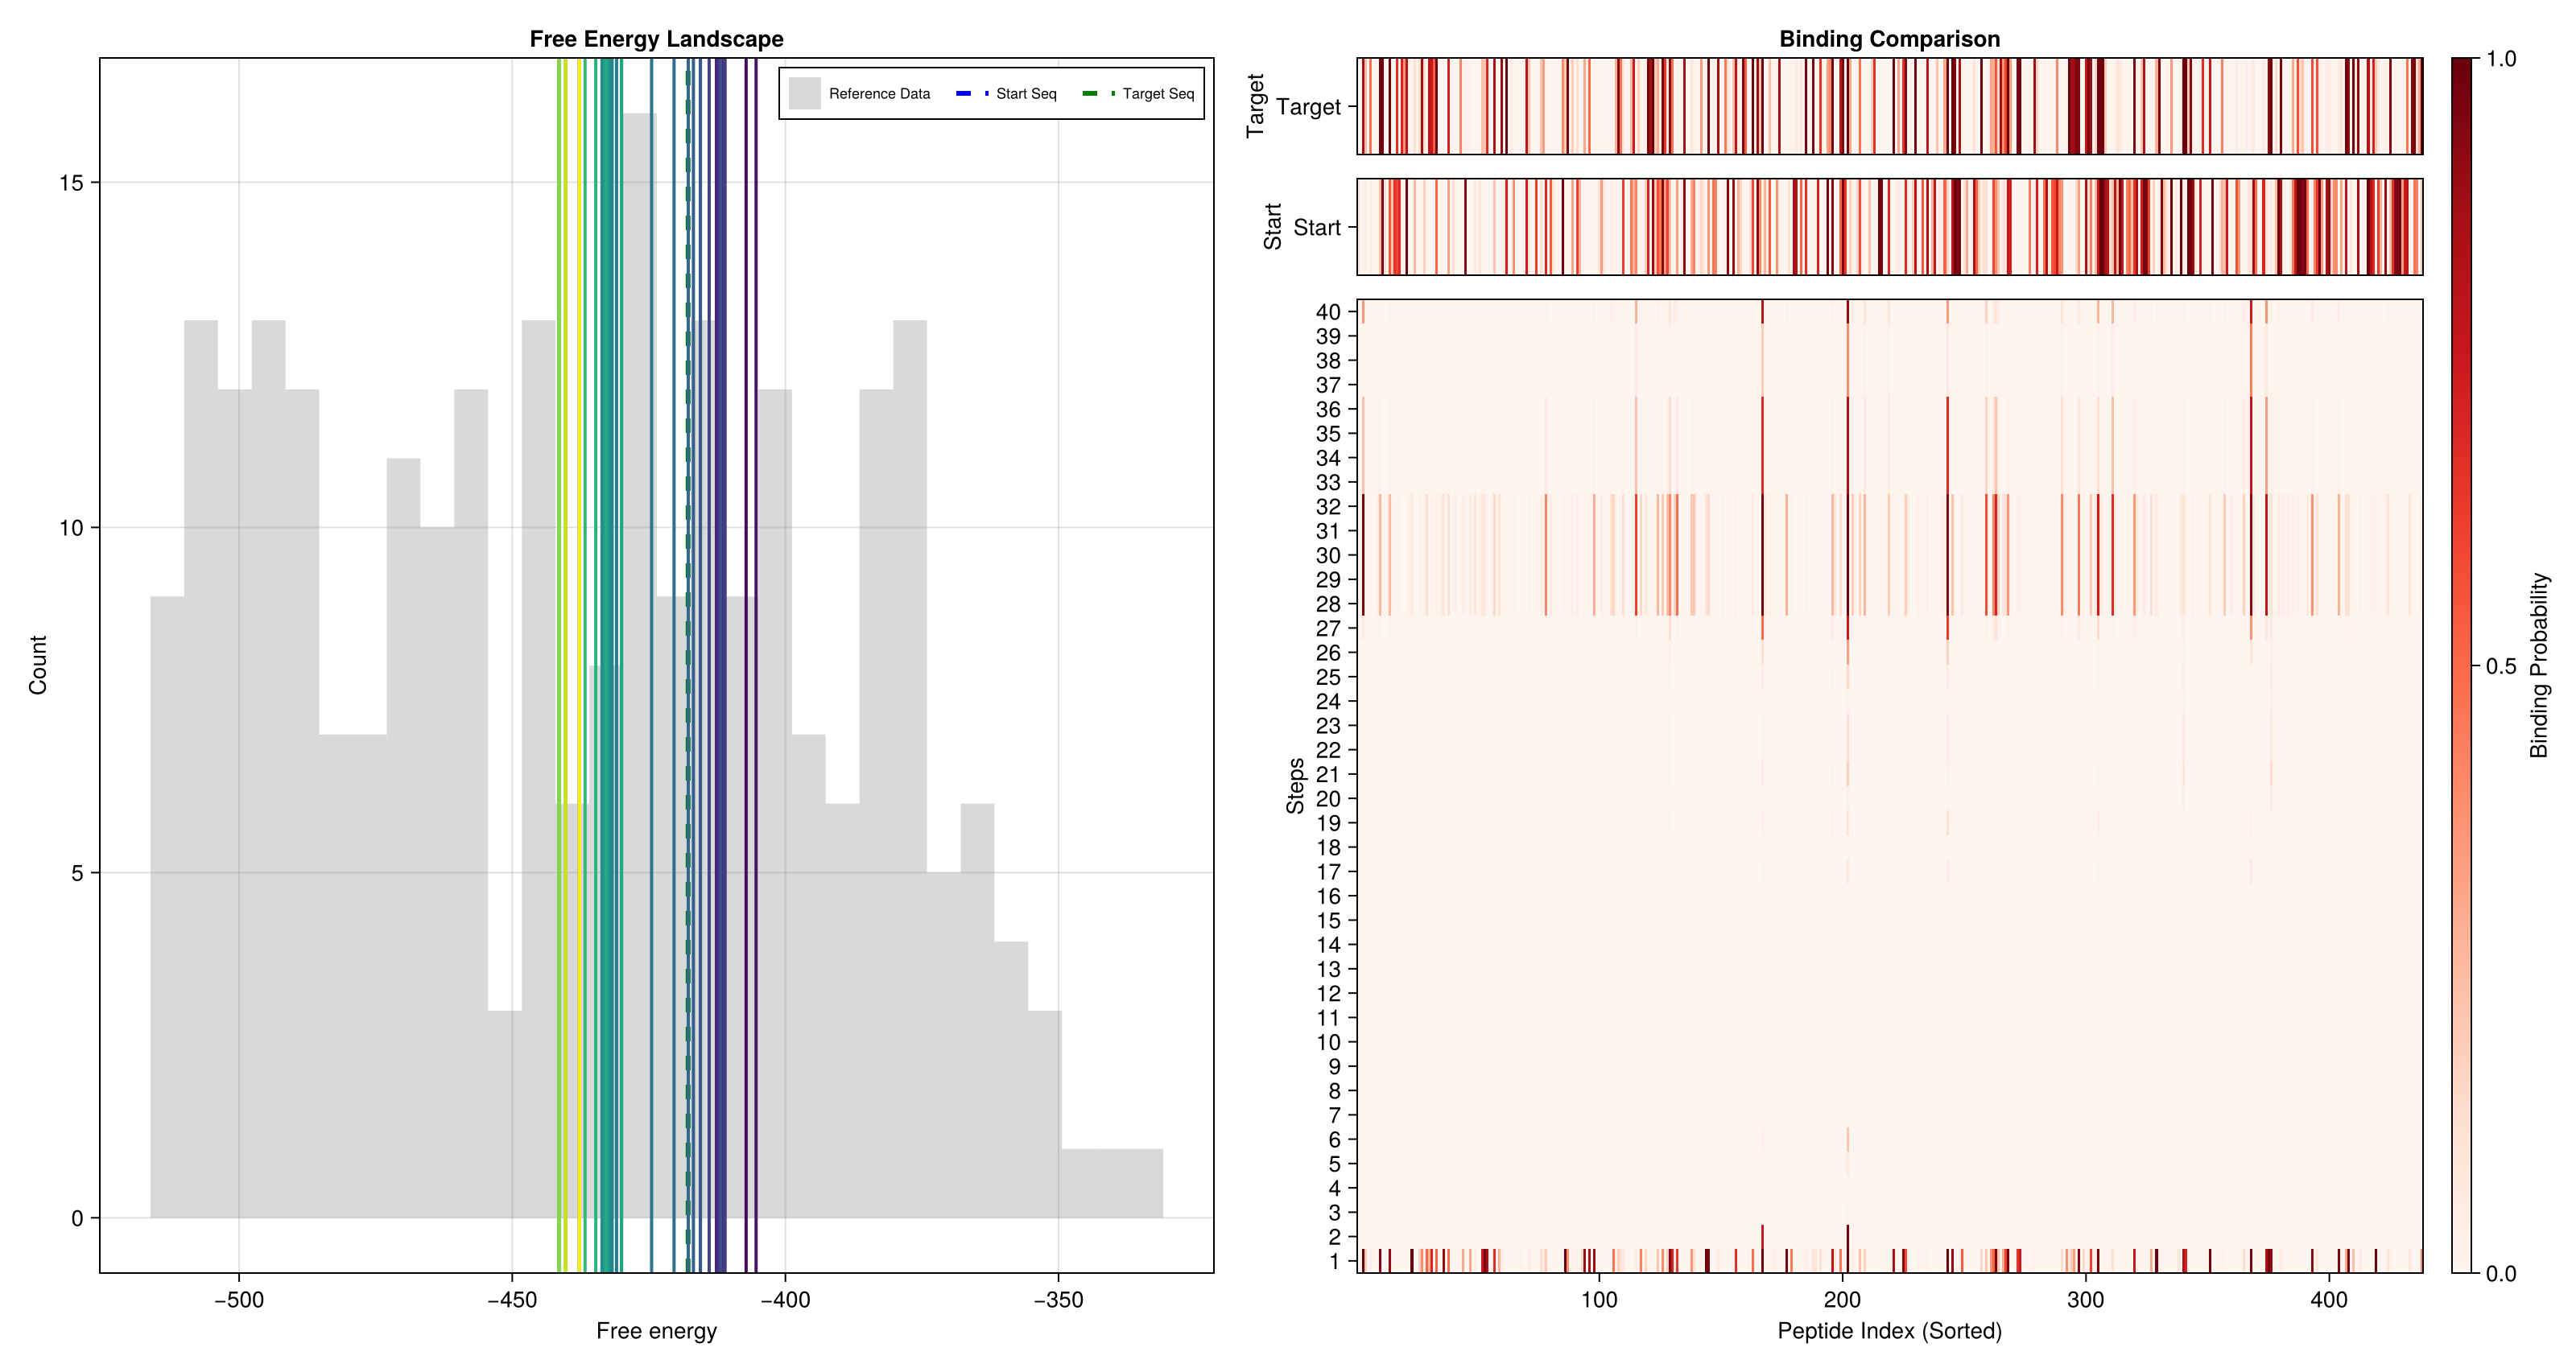

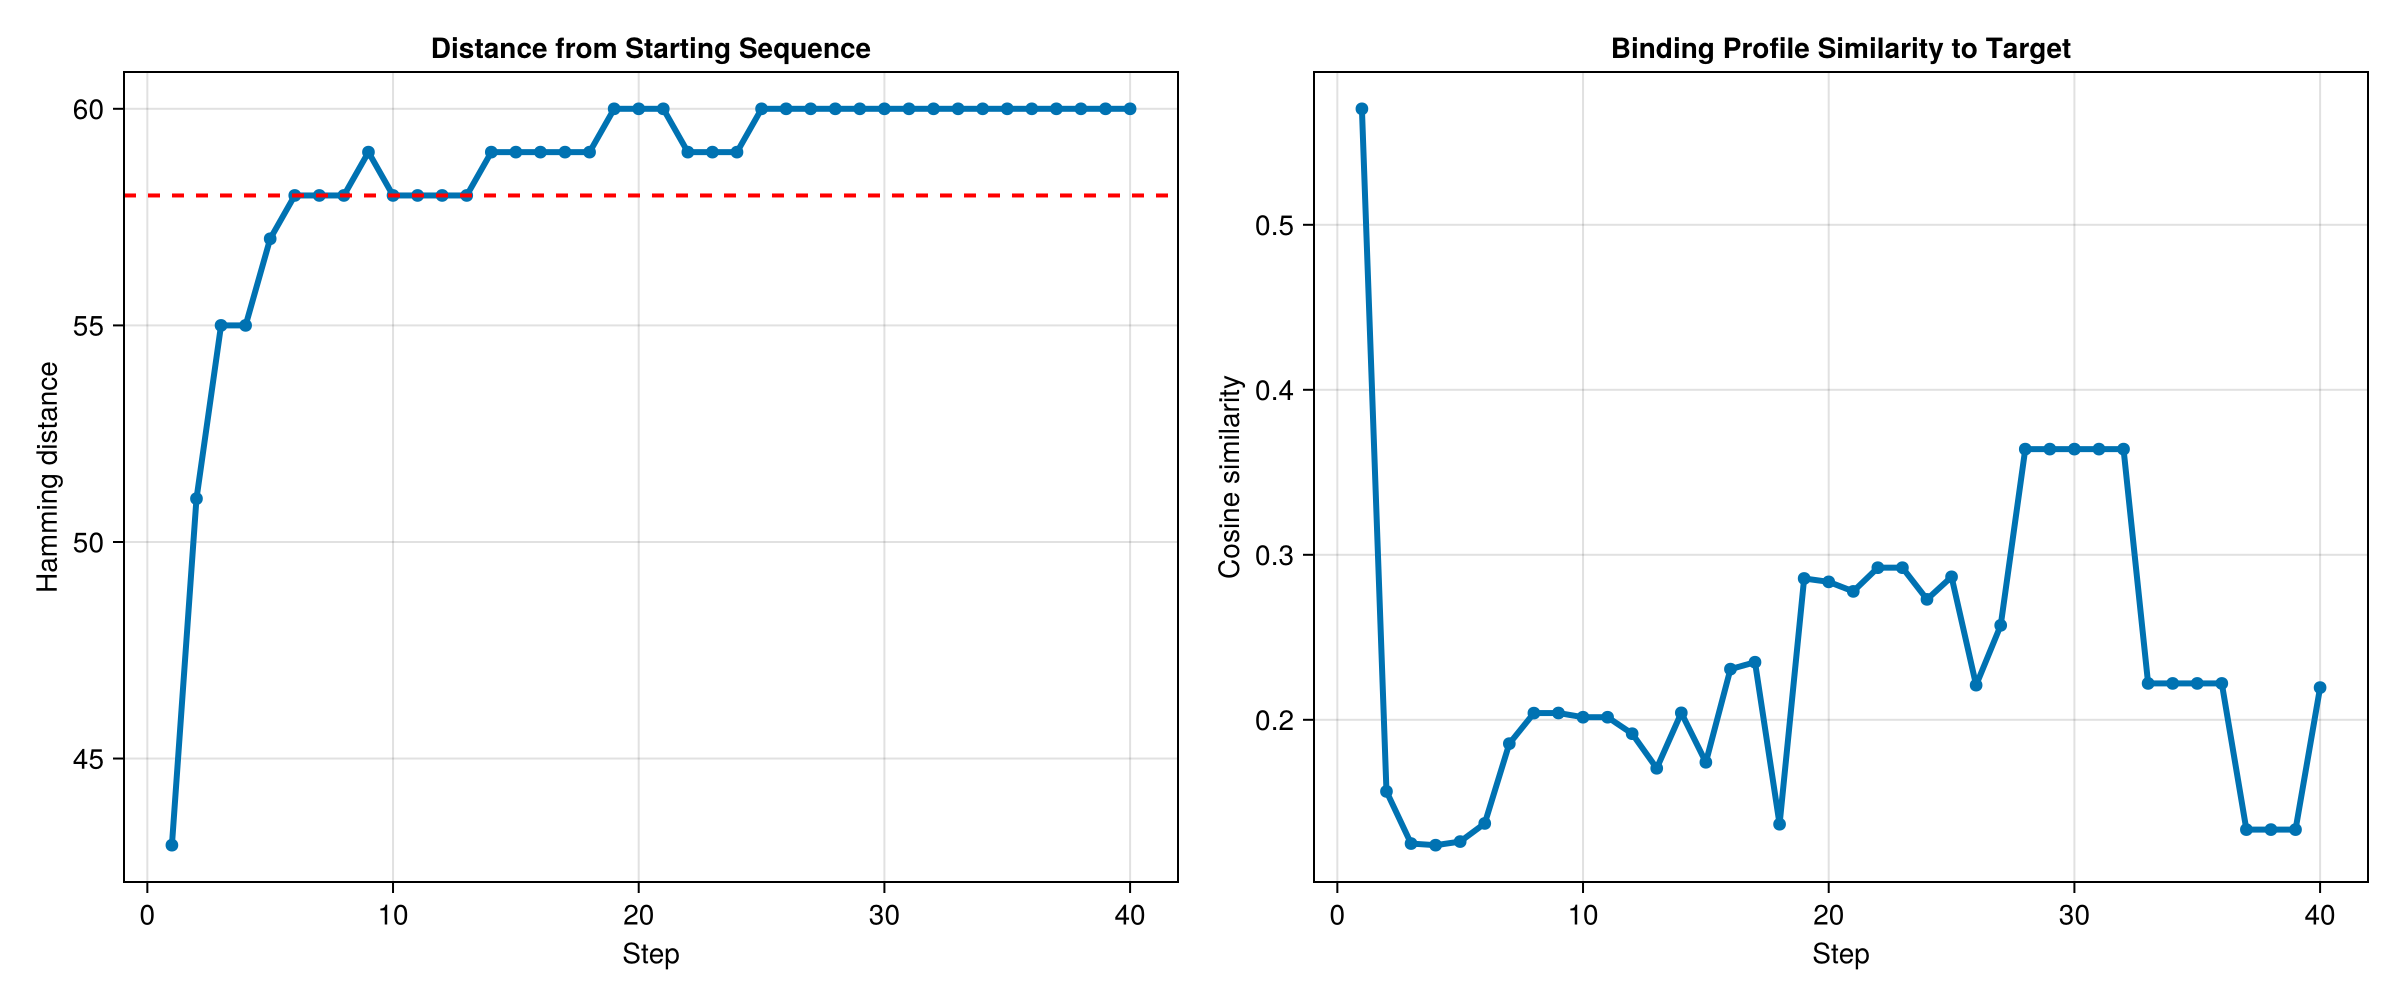

CairoMakie.Screen{IMAGE}


In [9]:
# 1. Configuration
steps = 40
m = 125                          # Index for the starting PDZ
n = 126                           # Index for the target PDZ

# 2. Data Selection
keys_list = collect(keys(data_Gogl))

starting_seq = keys_list[m]     # Start sequence (String)
target_key   = keys_list[n]     # Target sequence name (String)
target_tuple = data_Gogl[target_key] # The NamedTuple containing .elements

# 3. Execution
println("Starting Sequence: ", starting_seq)
println("Target Sequence:   ", target_key)
println("Number of peptides in target: ", size(target_tuple.elements))

fig, fig2 = plot_energy_and_binding_profile(
    rbm,
    data_Gogl,
    alphabet,
    alphabet_dict,
    starting_seq,
    target_key,
    target_tuple,
    n_release,
    steps
)

# Display in your notebook or IDE
display(fig)
display(fig2)

In [ ]:
save("energy_binding_profile_$(starting_seq)_to_$(target_key).png",fig)


Starting Sequence: TVTLNMEKYNFLGISIVGQSNERDGGIYIGSIMKGGAVAADGIEPGDMLLQVNEINFENMSNDDAVRVLRE----------
Target Sequence:   --IIQK-DQHGFGFTVSGD-----RIVLVQSVRPGGAAMKAGVKEGDRIIKVNGTMVTNSSHLEVVKLIKSGA-YVALT--
Number of peptides in target: (448,)


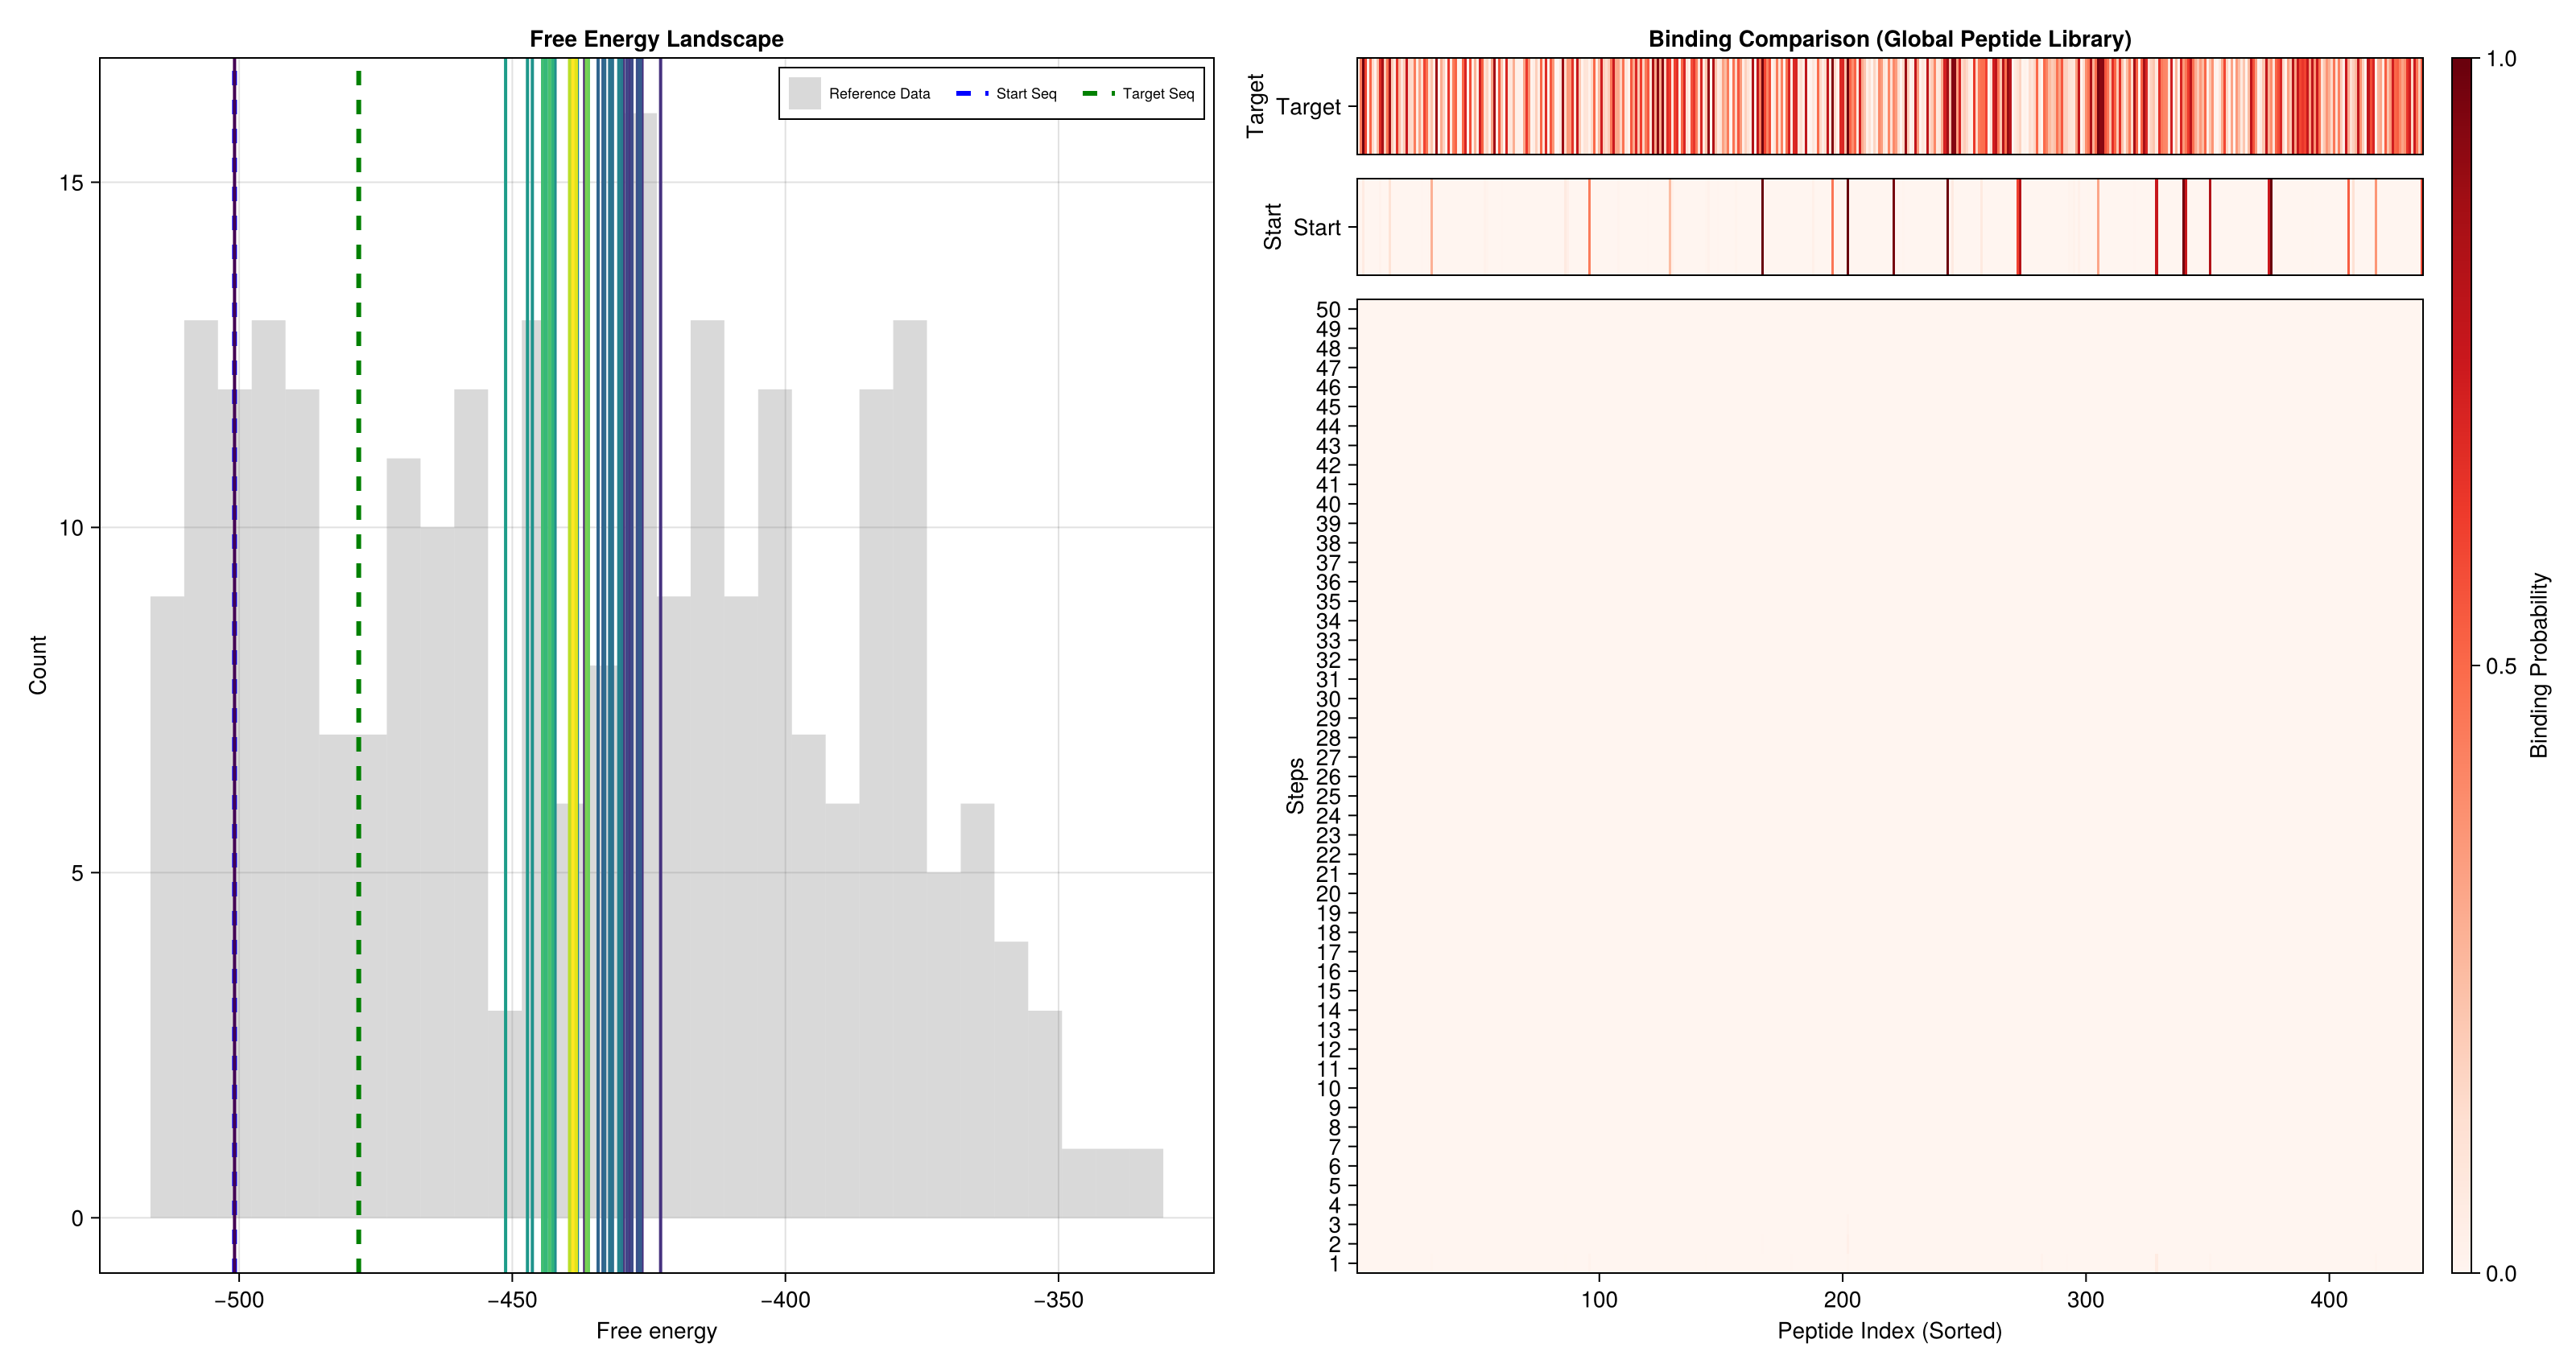

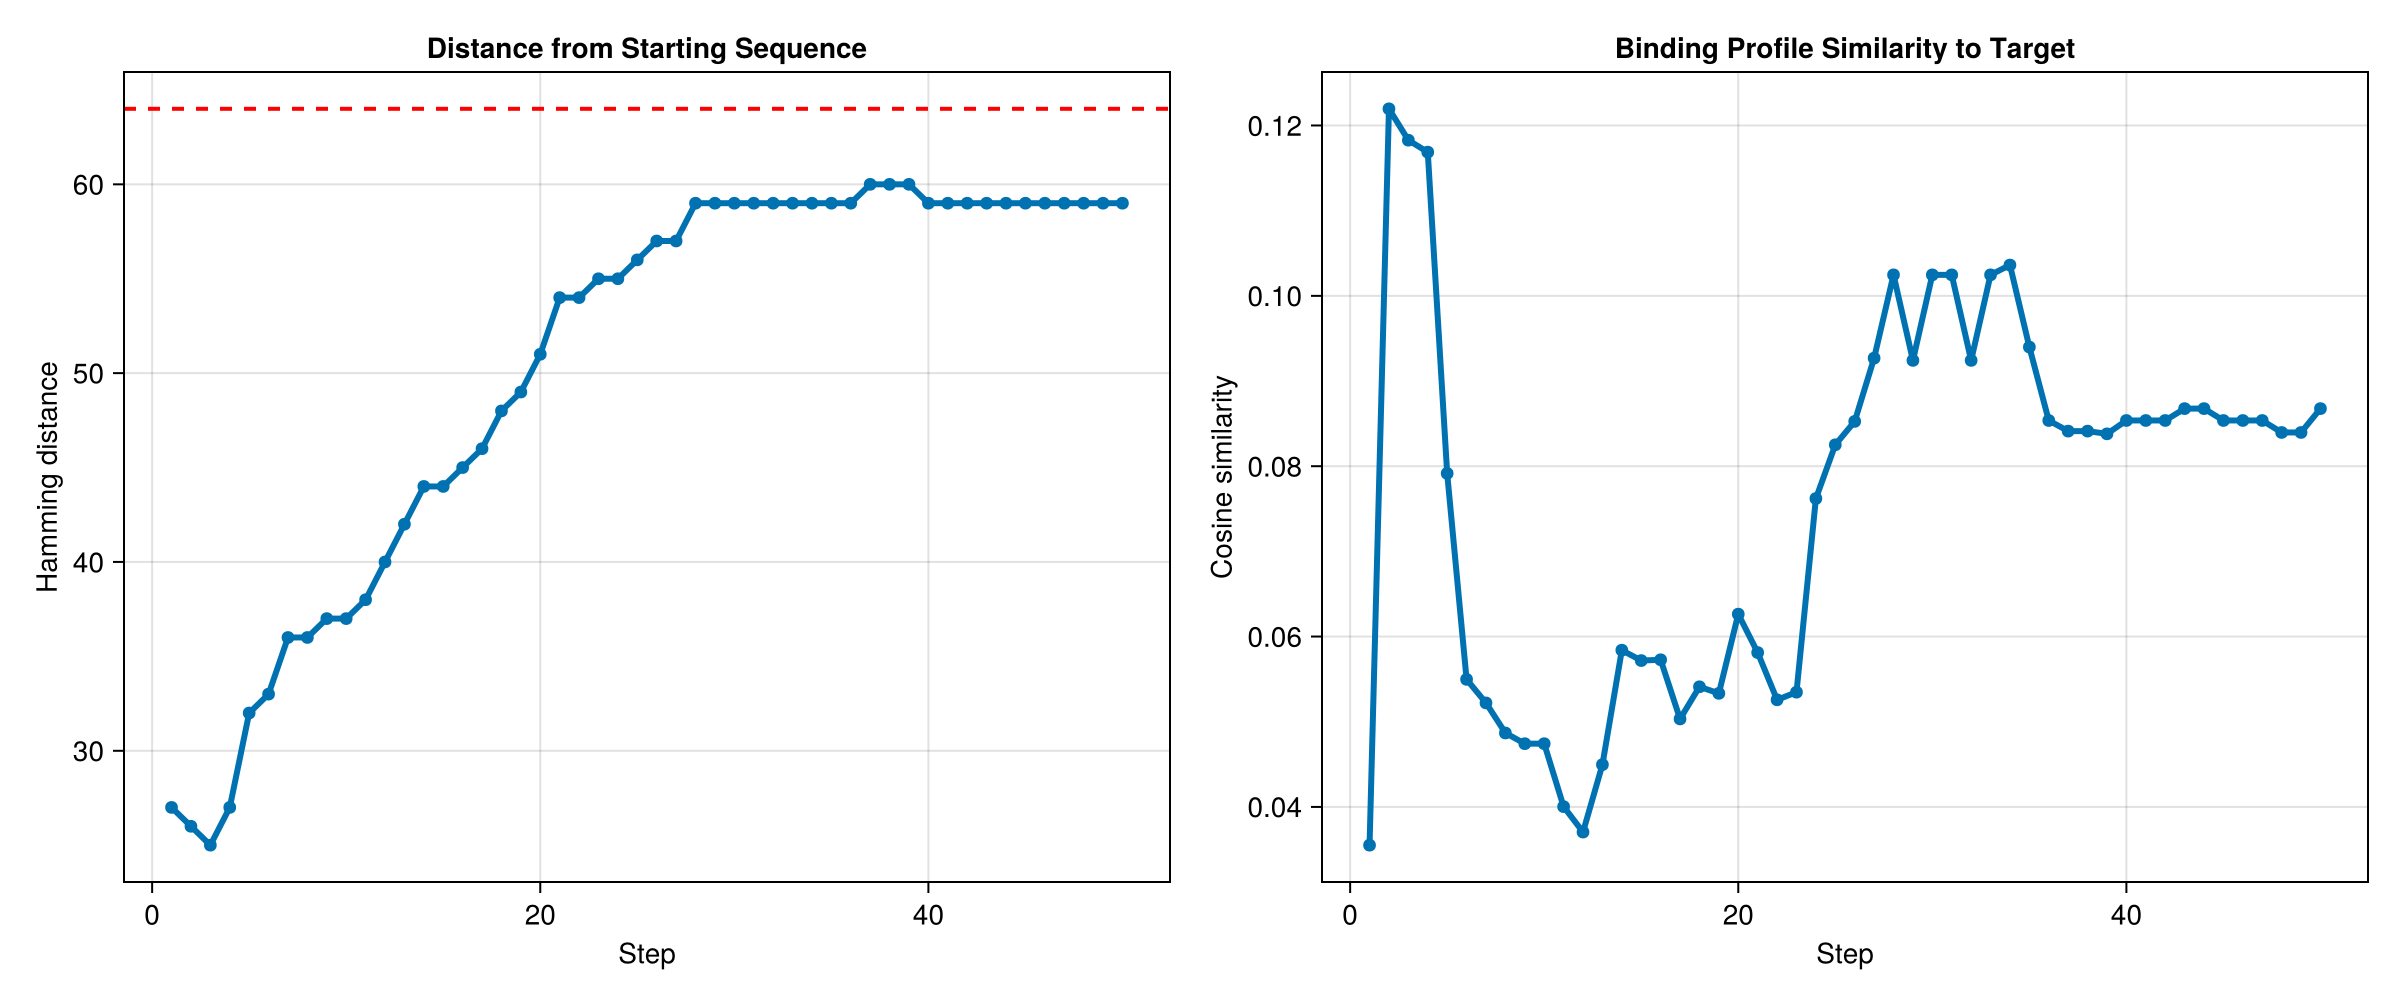

CairoMakie.Screen{IMAGE}


In [13]:
# 1. Configuration
steps = 50
m = 250                          # Index for the starting PDZ
n = 54                           # Index for the target PDZ

# 2. Data Selection
keys_list = collect(keys(data_Gogl))

starting_seq = keys_list[m]     # Start sequence (String)
target_key   = keys_list[n]     # Target sequence name (String)
target_tuple = data_Gogl[target_key] # The NamedTuple containing .elements

# 3. Execution
println("Starting Sequence: ", starting_seq)
println("Target Sequence:   ", target_key)
println("Number of peptides in target: ", size(target_tuple.elements))

fig, fig2 = plot_energy_and_equilibrate(
    rbm,
    data_Gogl,
    alphabet,
    alphabet_dict,
    starting_seq,
    target_key,
    target_tuple,
    n_release,
    steps
)

# Display in your notebook or IDE
display(fig)
display(fig2)

Starting Sequence: ----------GLGFNIVGGEDG--EGIFVSFILAGGPADLSGLQRGDQILSVNGIDLRGASHEQAAAALKGAGQTVTI---
Target Sequence:   ----------GLGFSIAGGKGSTDGGIFISRIAEGGAAHRAGLQVGDRVLSINGVDMTEARHDHAVSLLTAASPTISLLL-
Number of peptides in target: (210,)


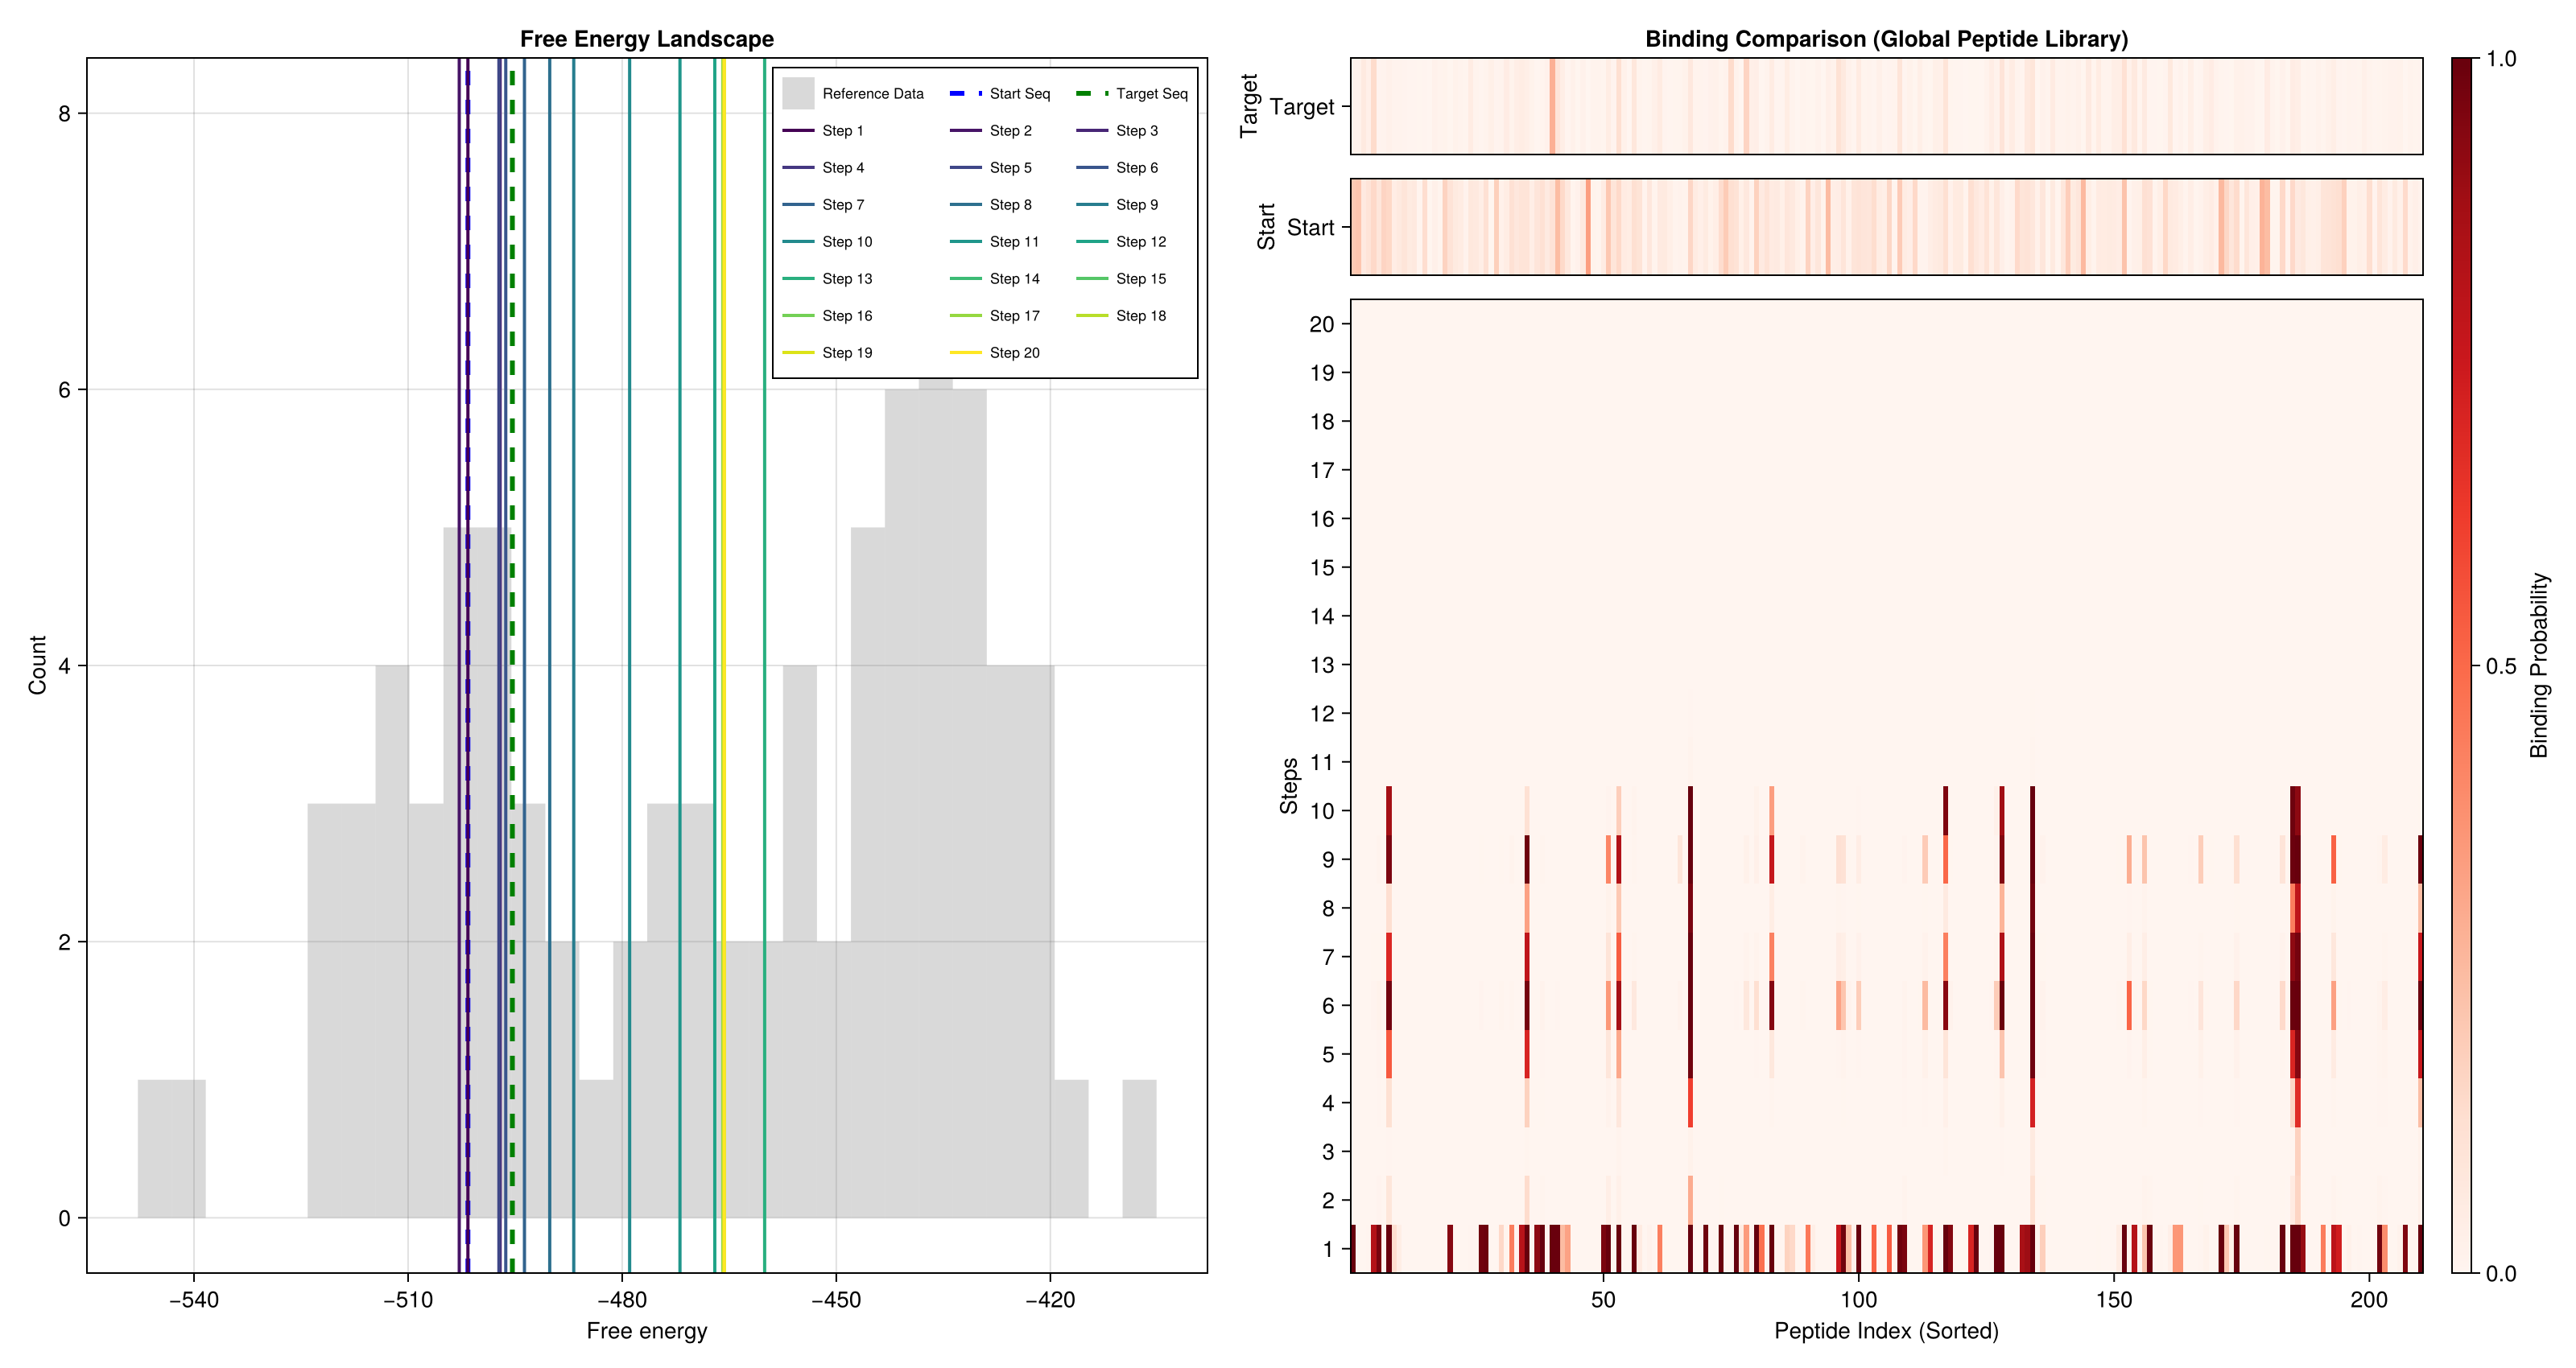

In [64]:
# 1. Configuration
steps = 20
m = 20                          # Index for the starting PDZ
n = 40                           # Index for the target PDZ

# 2. Data Selection
keys_list = collect(keys(data_Stiffler))

starting_seq = keys_list[m]     # Start sequence (String)
target_key   = keys_list[n]     # Target sequence name (String)
target_tuple = data_Stiffler[target_key] # The NamedTuple containing .elements

# 3. Execution
println("Starting Sequence: ", starting_seq)
println("Target Sequence:   ", target_key)
println("Number of peptides in target: ", size(target_tuple.elements))

fig = plot_energy_and_binding_profile(
    rbm,
    data_Stiffler,
    alphabet,
    alphabet_dict,
    starting_seq,
    target_key,
    target_tuple,
    n_release,
    steps
)

# Display in your notebook or IDE
fig

Starting Sequence: ----------GFGFSLRGGKEYN-MGLFILRLAEDGPAIKDGIHVGDQIVEINGEPTQGITHTRAIELIQAGGNKVLLLL-
Target Sequence:   ----------GLGFSIAGGKGSTDGGIFISRIAEGGAAHRAGLQVGDRVLSINGVDMTEARHDHAVSLLTAASPTISLLL-
Number of peptides in target: (210,)


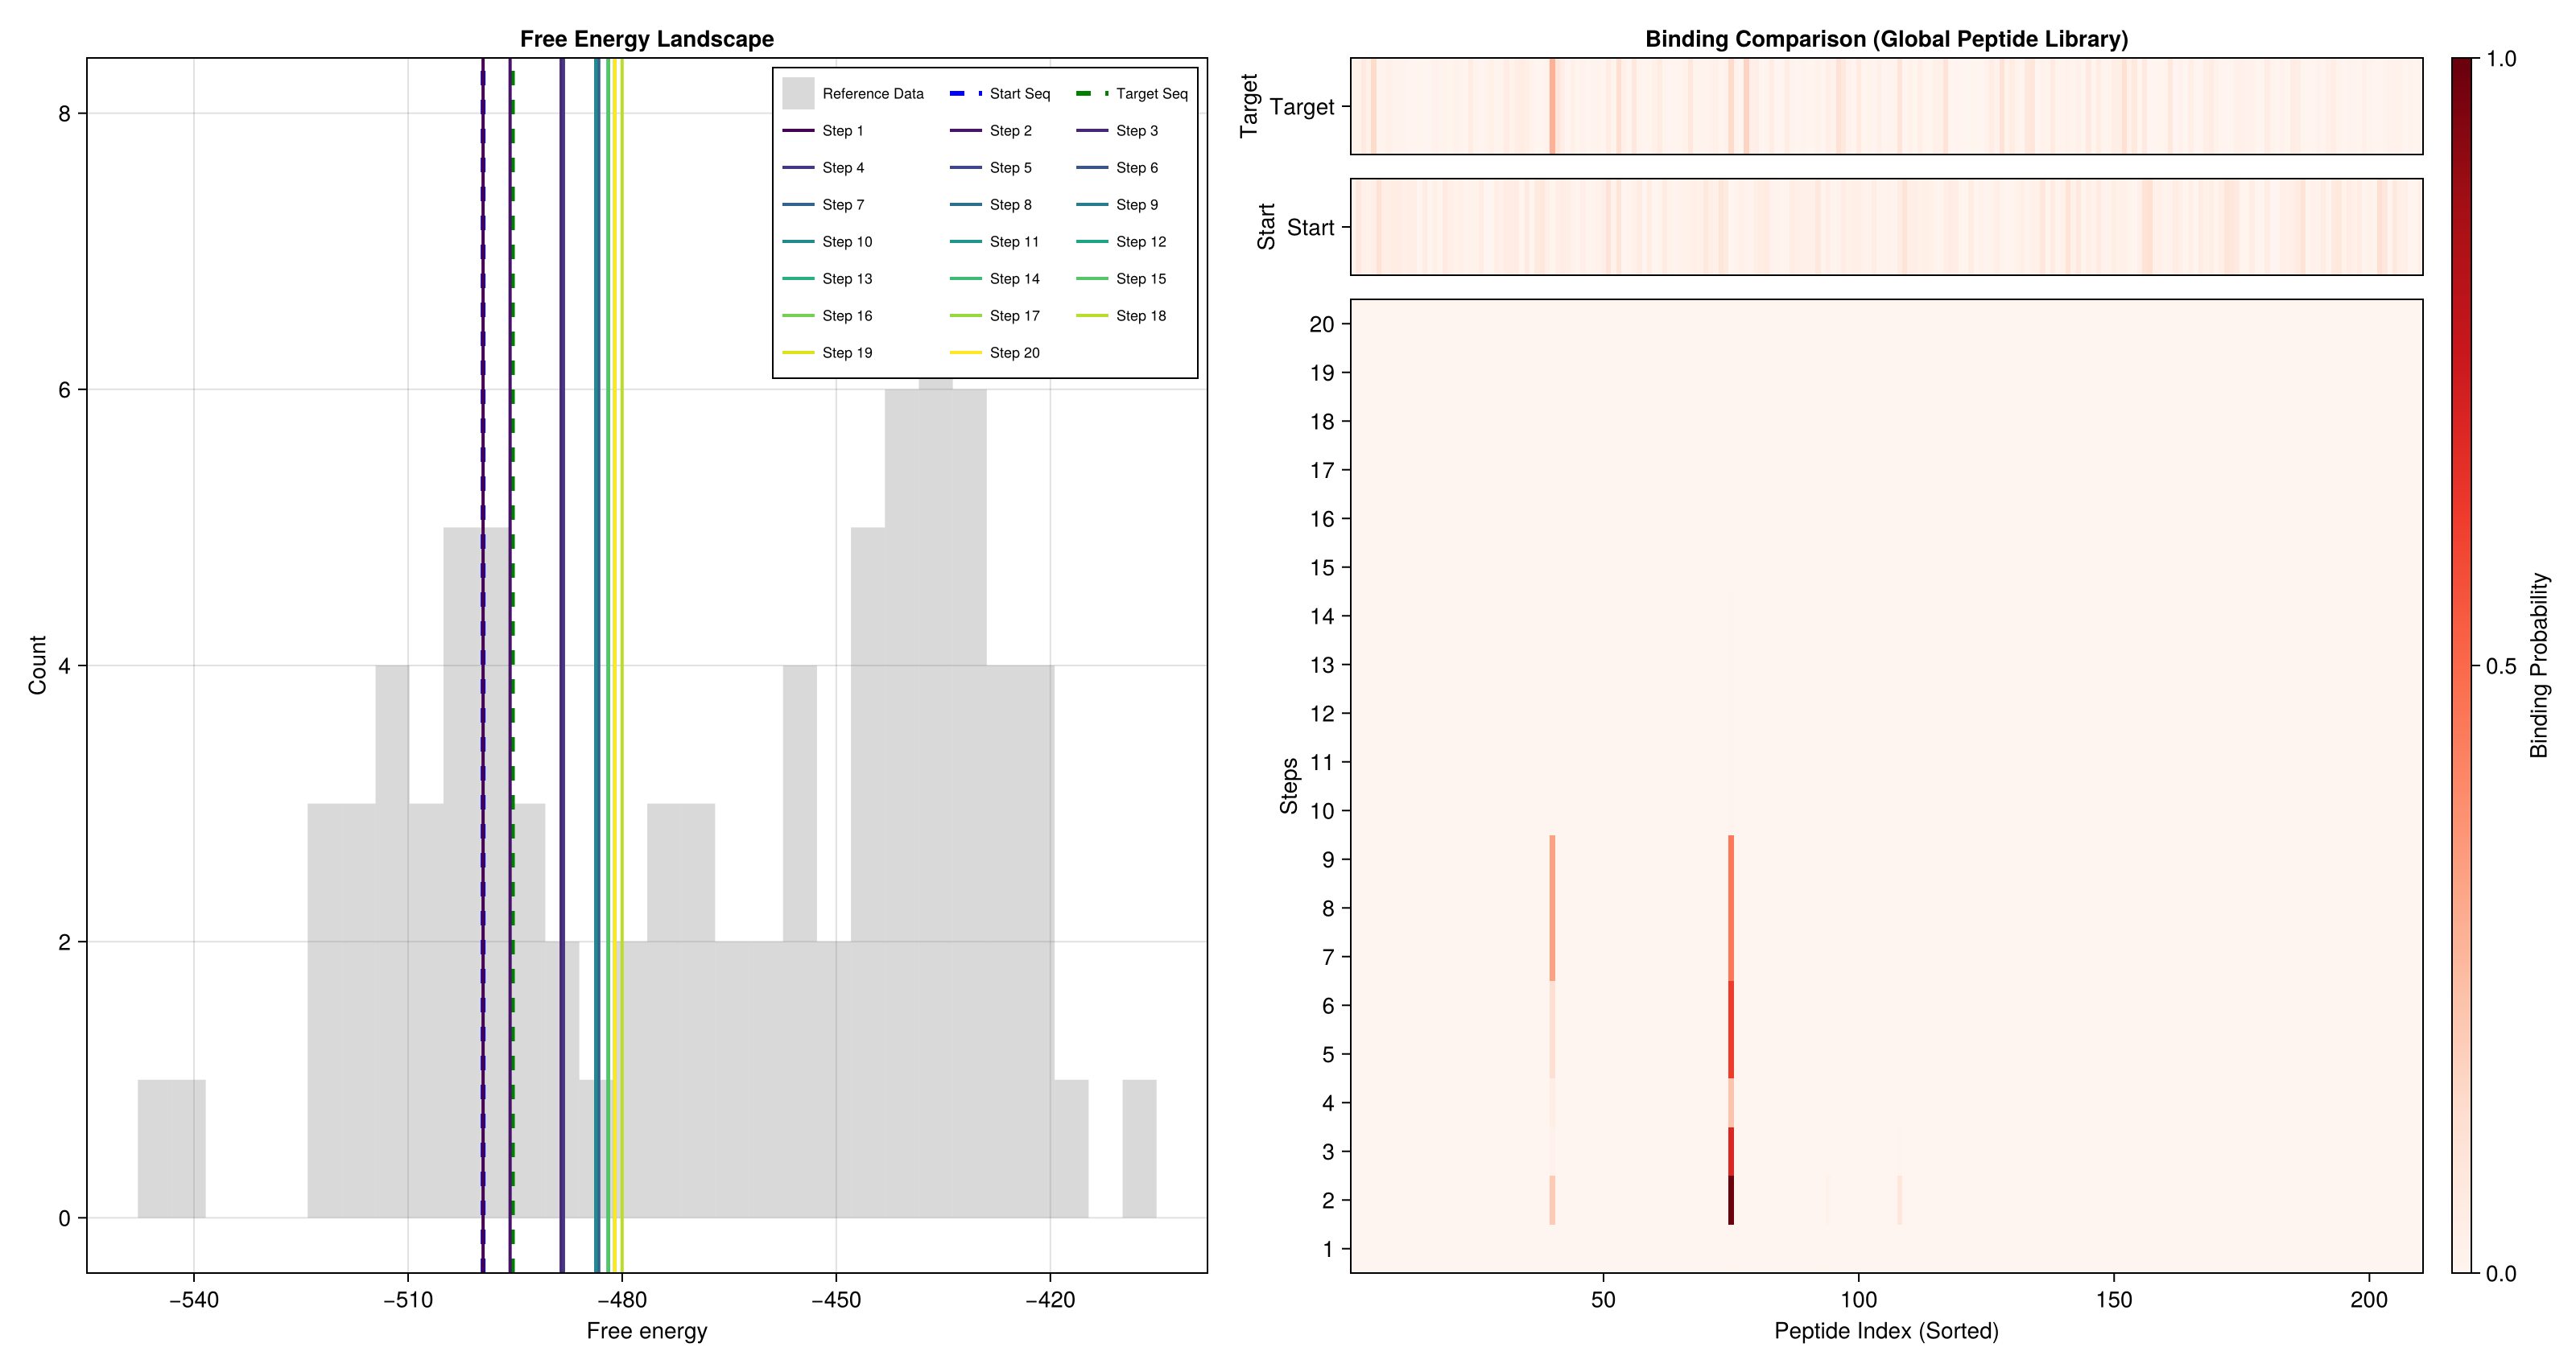

: 

In [ ]:
# 1. Configuration
steps = 20
m = 16                          # Index for the starting PDZ
n = 40                           # Index for the target PDZ

# 2. Data Selection
keys_list = collect(keys(data_Stiffler))

starting_seq = keys_list[m]     # Start sequence (String)
target_key   = keys_list[n]     # Target sequence name (String)
target_tuple = data_Stiffler[target_key] # The NamedTuple containing .elements

# 3. Execution
println("Starting Sequence: ", starting_seq)
println("Target Sequence:   ", target_key)
println("Number of peptides in target: ", size(target_tuple.elements))

fig = plot_energy_and_equilibrate(
    rbm,
    data_Stiffler,
    alphabet,
    alphabet_dict,
    starting_seq,
    target_key,
    target_tuple,
    n_release,
    steps
)

# Display in your notebook or IDE
fig

Total unique sequences: 438
Number of unique labels: 1
Alphabet size: 21
Alphabet: -ACDEFGHIKLMNPQRSTVWY
Feature matrix size: (210, 438)


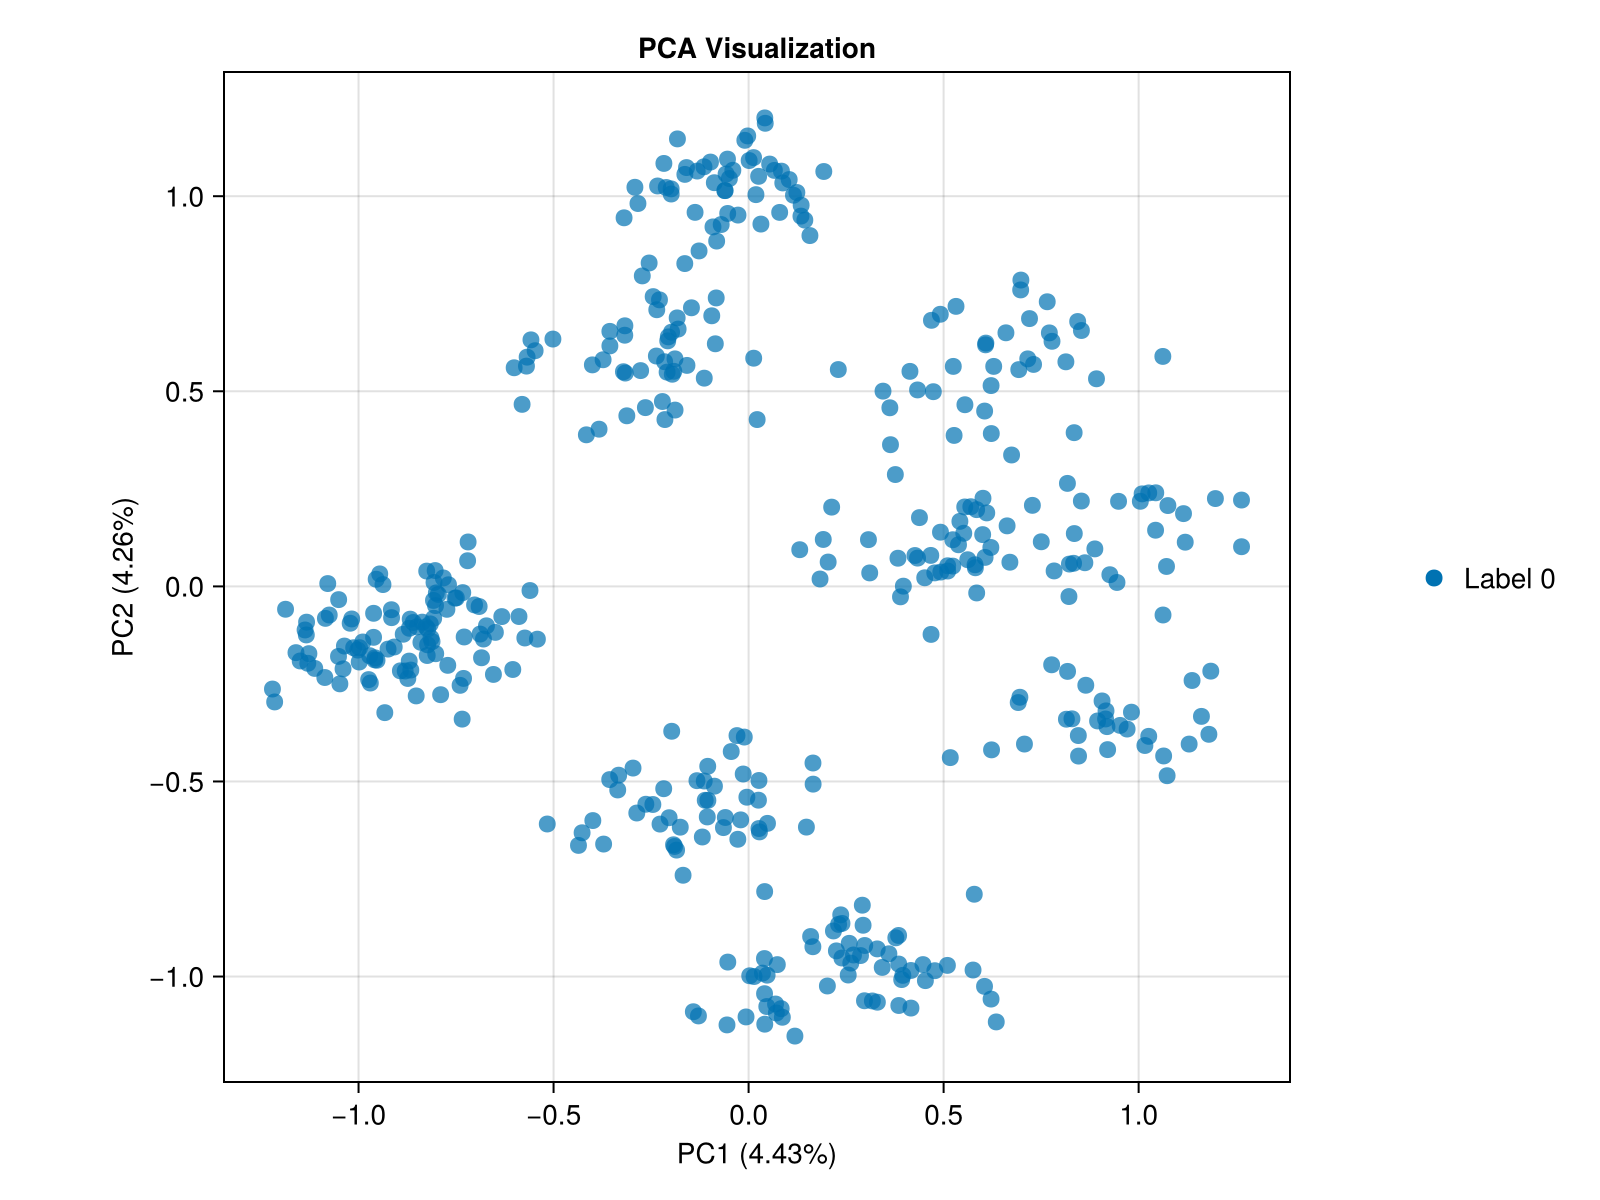

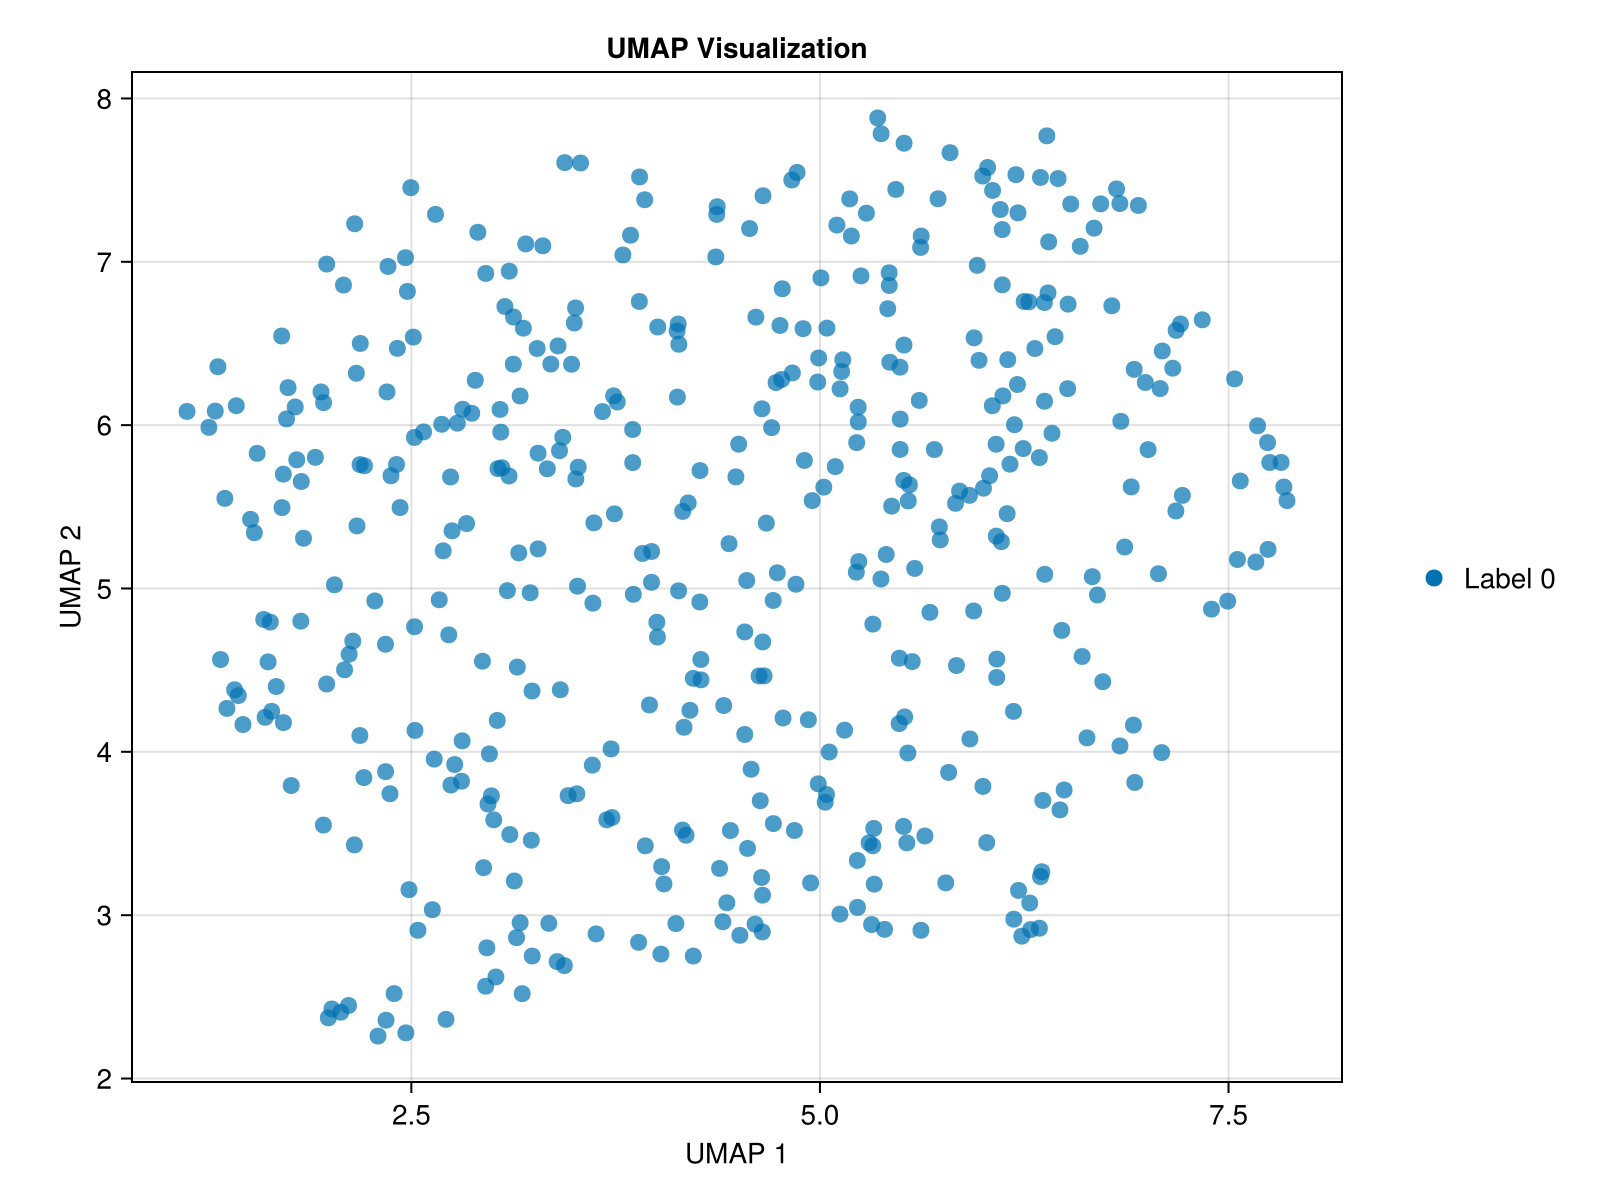

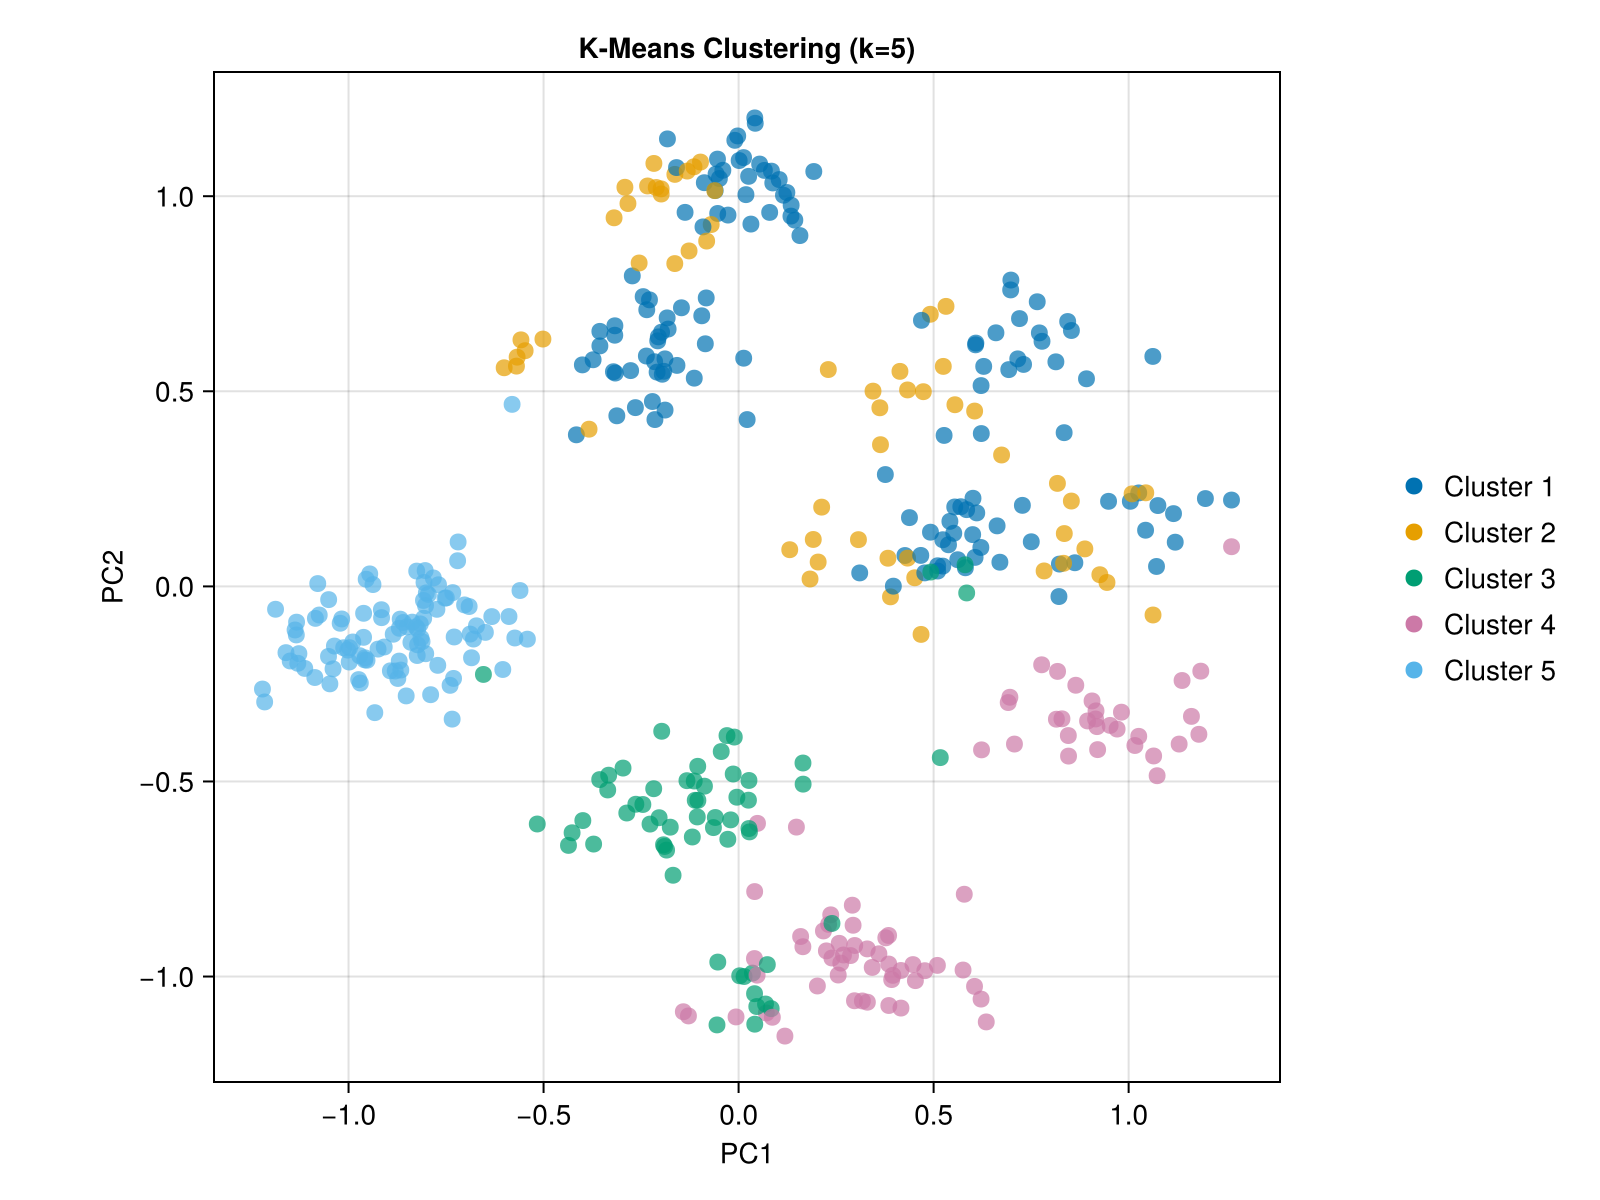

(pca = Float32[1.0160455 -0.40782717; 0.34461895 0.50038874; … ; 0.62225324 0.391676; -0.80215615 -0.17256288], umap = [1.5968143295435397 4.51004845987194 … 3.0174607601887344 5.251059092892938; 4.810406395010736 2.876579810647798 … 2.621650820958736 6.91362267438506], kmeans = [4, 2, 3, 5, 5, 5, 1, 5, 5, 4  …  1, 1, 1, 4, 3, 3, 3, 2, 1, 5], labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sequences = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRRETQL", "RLQRRRETQV", "WKPTRRETEV", "SEKHFRETEV", "KPPLPPDEWV", "SGGKRKETLV", "EDQHTQITKV", "RVRKLPSTTL"  …  "SLNANEVEWF", "KSTTRSSSSC", "PSVYSRSQYV", "GQEEQVTTRL", "TASPAKETSF", "SNAGNTATKA", "LSEFKAMDSI", "QKNKDREYYV", "TISFTQTSQF", "TKEIPNCTSV"], pca_model = PCA(indim = 210, outdim = 2, principalratio = 0.08682791), fig_pca = Scene (800px, 600px):
  0 Plots
  2 Child Scenes:
    ├ Scene (800px, 600px)
    └ Scene (800px, 600px), fig_umap = Scene (800px, 600px):
  0 Plots
  2 Child Scenes:
    ├ Scene (800px, 600px)
    └ Scen

In [32]:
include("specificity_helpers.jl")
results = analyze_peptides(data_Gogl, n_clusters=5, n_components=2)


Let's try to understand a bit the space of these binding profile.  First thing we try is 

In [70]:
include("LogisticPCA.jl")
X, feature_names = prepare_data(data_Gogl)
X_filled, M = create_mask_and_data(X)
    
n, p = size(X_filled)
println("Data shape: $n samples × $p features")
println("Number of observed entries: $(sum(M))")
println("Features: ", feature_names)
println()
    
    # Initialize and fit model
k = 5  # number of latent dimensions
model = LogisticPCA(n, p, k; λz=0.05, λw=0.05)
    
println("Fitting Logistic PCA with k=$k latent dimensions...\n")
fit_PCA!(model, X_filled, M; epochs=2000, lr=0.05, verbose=true, print_every=200)
    
    # Display results
println("\n=== Results ===")
println("\nLatent scores Z (samples × latent dimensions):")
display(round.(model.Z, digits=3))
    
println("\n\nLoadings W (features × latent dimensions):")
for (i, feat) in enumerate(feature_names)
    println("$feat: ", round.(model.W[i, :], digits=3))
end
    
println("\n\nIntercepts α:")
for (i, feat) in enumerate(feature_names)
    println("$feat: ", round(model.α[i], digits=3))
end
    
    # Compute predicted probabilities
P = predict_probs(model, X_filled)
println("\n\nPredicted probabilities (samples × features):")
display(round.(P, digits=3))
    


Data shape: 254 samples × 438 features
Number of observed entries: 65163
Features: ["-INTERNAL-", "AAVENKVTDL", "ADEMICITTL", "ADENEQVSAV", "ADRDHASDQL", "AEASVACSLC", "AEDEEIQTKM", "AHGSTRDQSI", "AKADAQESRL", "AKPQPVDSWV", "AKPSRISTVV", "ALPLPQSSTC", "ANGLMQTSKL", "APIAGFSSFV", "APSRKLNTEI", "AQRARSPSDV", "ARESQKVSHV", "ARGPPRESEV", "ARSAAASNYV", "ASGLDKRDYV", "ATKDKKITTV", "CLDTSRETDL", "CLREWCDAFL", "CNTVTVETVV", "DAAHHDESNC", "DDASLPVSDV", "DDEDRLVIEI", "DDENIRTSDV", "DDPSTAETVL", "DFKHTKSFII", "DFLSTFHIRI", "DFRHKSSFVI", "DGVNEKVSCV", "DHLGGGGESM", "DKDPHSETAL", "DLDEEEDTHL", "DLLGGGSDSI", "DPAESMESLV", "DPLTPSRSQL", "DPRNTQTSQI", "DQPLEKSTKL", "DRIQSCLSDA", "DSATVRTYSC", "DSEEELPTRL", "DTKNYKQTSV", "DTLEKFVEGL", "DTTLVEDTVL", "DTTVPESEDL", "DYSNLRETDI", "EALLQMESVA", "EAVTVESTSL", "EDEDEQVSAV", "EDGESWEYQI", "EDLEDEWEVI", "EDLTKNHDEL", "EDPRVEVTQF", "EDQHTQITKV", "EEDTAEKDEL", "EEPEERHTEL", "EFKQTSSFLV", "EGGKKRESEA", "EIPAQSPTCV", "EKCGKEFSEF", "EKKTLIGIKL", "EKLSSIESDV", "EKPID

254×5 Matrix{Float64}:
  0.961   1.494  -0.719   1.374   0.223
  0.961   1.494  -0.719   1.374   0.223
  0.127   2.251  -0.431   3.14    2.075
  0.961   1.494  -0.719   1.374   0.223
  0.961   1.494  -0.719   1.374   0.223
  1.205  -0.434   0.311   1.491  -1.039
  0.961   1.494  -0.719   1.374   0.223
  0.667   0.176   2.897   0.805  -0.406
  0.961   1.494  -0.719   1.374   0.223
  2.097   1.342   0.778   1.859   0.227
  8.772   4.205   4.508   3.052  -0.268
 -0.512   0.842   0.056  -0.521   0.235
  0.961   1.494  -0.719   1.374   0.223
  ⋮                              
  1.634   2.044  -2.631   1.843   1.817
  0.961   1.494  -0.719   1.374   0.223
  1.837   1.155  -3.057   1.386   0.766
  1.299  -0.908   3.729   4.467  -0.017
  0.961   1.494  -0.719   1.374   0.223
  3.466  -3.62   -2.189  -0.349   6.51
  0.961   1.494  -0.719   1.374   0.223
  0.962   1.494  -0.719   1.374   0.223
  2.131   2.341   0.578   1.542   1.355
  0.961   1.494  -0.719   1.374   0.223
  1.448  -0.638  -0.3   



Loadings W (features × latent dimensions):
-INTERNAL-: [-0.356, 0.032, 0.242, -0.167, -0.462]
AAVENKVTDL: [-0.144, -1.474, 1.5, -1.706, -0.332]
ADEMICITTL: [-0.15, -0.708, 0.324, -1.069, -0.7]
ADENEQVSAV: [0.711, -2.035, 1.216, -1.243, -0.174]
ADRDHASDQL: [-3.452, 1.327, -0.2, -0.906, -3.311]
AEASVACSLC: [0.625, -0.7, 1.293, -1.461, -1.582]
AEDEEIQTKM: [-1.131, 0.216, -0.513, -2.795, -0.907]
AHGSTRDQSI: [-0.806, 0.174, 0.52, -0.23, 0.094]
AKADAQESRL: [-1.668, -0.316, -0.631, -3.306, 0.328]
AKPQPVDSWV: [0.984, -0.883, 1.788, 0.024, 0.999]
AKPSRISTVV: [-1.646, -1.965, 0.937, 0.406, -0.888]
ALPLPQSSTC: [0.75, -0.993, 1.419, -1.324, -2.506]
ANGLMQTSKL: [-0.731, -1.354, -0.265, -2.604, -1.578]
APIAGFSSFV: [0.735, -1.736, 1.646, -0.543, -0.627]
APSRKLNTEI: [-0.271, -0.802, 0.326, -0.403, -1.056]
AQRARSPSDV: [0.323, -0.655, 0.171, 0.051, -0.363]
ARESQKVSHV: [0.351, -2.422, 1.129, -0.364, -0.335]
ARGPPRESEV: [-1.786, -2.168, 1.288, -0.657, 1.628]
ARSAAASNYV: [0.304, -0.607, 1.102, 0.033, -1.

254×438 Matrix{Float64}:
 0.001  0.001  0.143  0.0    0.003  …  0.044  0.022  0.0    0.027  0.093
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 0.0    0.0    0.005  0.0    0.0       0.01   0.002  0.0    0.006  0.038
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 0.001  0.086  0.652  0.025  0.004  …  0.401  0.585  0.011  0.123  0.924
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 0.003  0.839  0.803  0.198  0.009     0.988  0.584  0.002  0.677  1.0
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 0.001  0.004  0.131  0.001  0.0       0.147  0.028  0.0    0.02   0.958
 0.0    0.001  0.01   0.009  0.0    …  0.381  0.0    0.0    0.0    1.0
 0.002  0.202  0.762  0.004  0.465     0.53   0.125  0.001  0.412  0.109
 0.001  0.001  0.143  0.0    0.003     0.044  0.022  0.0    0.027  0.093
 ⋮                            

In [73]:
function pca_on_latent(model::LogisticPCA; n_components::Int = 2, center::Bool = true)
    Z = model.Z                    # n × k
    Zc = center ? Z .- mean(Z, dims=1) : Z

    # Covariance matrix in latent space
    C = cov(Zc; dims=1)

    # Eigen-decomposition
    eig = eigen(Symmetric(C))

    # Sort by descending eigenvalue
    idx = sortperm(eig.values, rev=true)

    values = eig.values[idx]
    vectors = eig.vectors[:, idx]

    # Select top components
    components = vectors[:, 1:n_components]        # k × n_components
    Z_pca = Zc * components                         # n × n_components

    explained_variance = values[1:n_components] ./ sum(values)

    return Z_pca, components, explained_variance
end

function plot_latent_pca(model::LogisticPCA;
                         clusters = nothing,
                         palette = Makie.wong_colors(),
                         markersize = 10)

    Z_pca, _, explained_var = pca_on_latent(model; n_components = 2)

    fig = Figure(resolution = (600, 500))
    ax = Axis(
        fig[1, 1],
        xlabel = "PC1 ($(round(explained_var[1]*100, digits=1))%)",
        ylabel = "PC2 ($(round(explained_var[2]*100, digits=1))%)",
        title  = "PCA of Logistic PCA latent space"
    )

    if clusters === nothing
        scatter!(
            ax,
            Z_pca[:, 1], Z_pca[:, 2];
            color = :dodgerblue,
            markersize = markersize,
            label = "Samples"
        )
        axislegend(ax)
    else
        unique_clusters = sort(unique(clusters))
        n_clusters = length(unique_clusters)

        for (i, c) in enumerate(unique_clusters)
            idx = findall(clusters .== c)

            scatter!(
                ax,
                Z_pca[idx, 1],
                Z_pca[idx, 2];
                color = palette[(i - 1) % length(palette) + 1],
                markersize = markersize,
                label = "Cluster $c"
            )
        end

        axislegend(ax; position = :rt)
    end

    fig
end


plot_latent_pca (generic function with 1 method)

Cluster sizes:
Cluster 1: 202
Cluster 2: 37
Cluster 3: 2
Cluster 4: 13


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


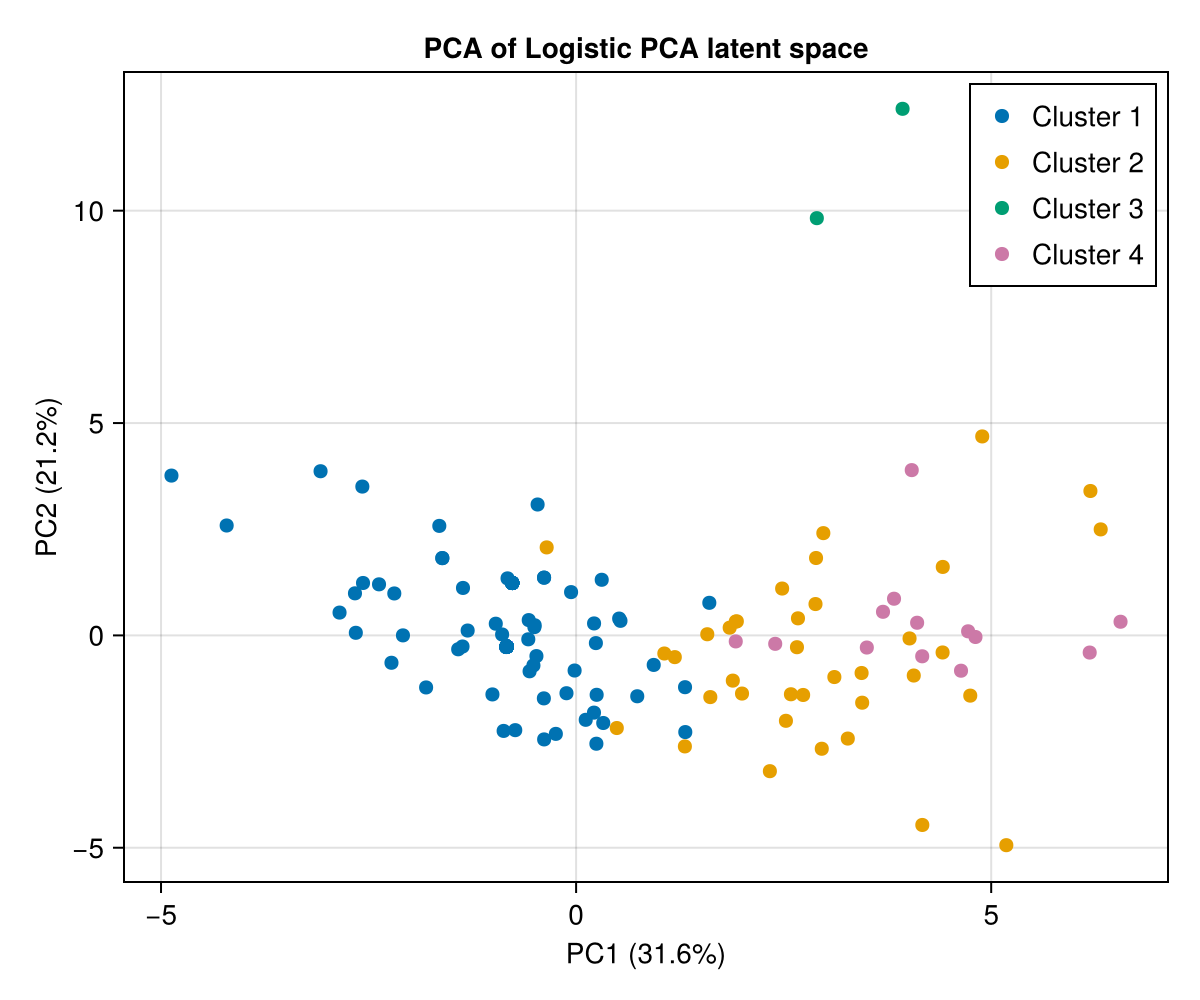

: 

In [ ]:
function cluster_latent(Z::Matrix{Float64}; n_clusters::Int = 3)
    result = kmeans(Z', n_clusters; maxiter = 300, display = :none)
    return result.assignments, result.centers
end
n_clusters = 4
labels, centers = cluster_latent(model.Z; n_clusters = n_clusters)
println("Cluster sizes:")
for c in 1:n_clusters
    println("Cluster $c: ", count(==(c), labels))
end
plot_latent_pca(model; clusters = labels)



Explained variance (%): [31.84, 8.22]


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


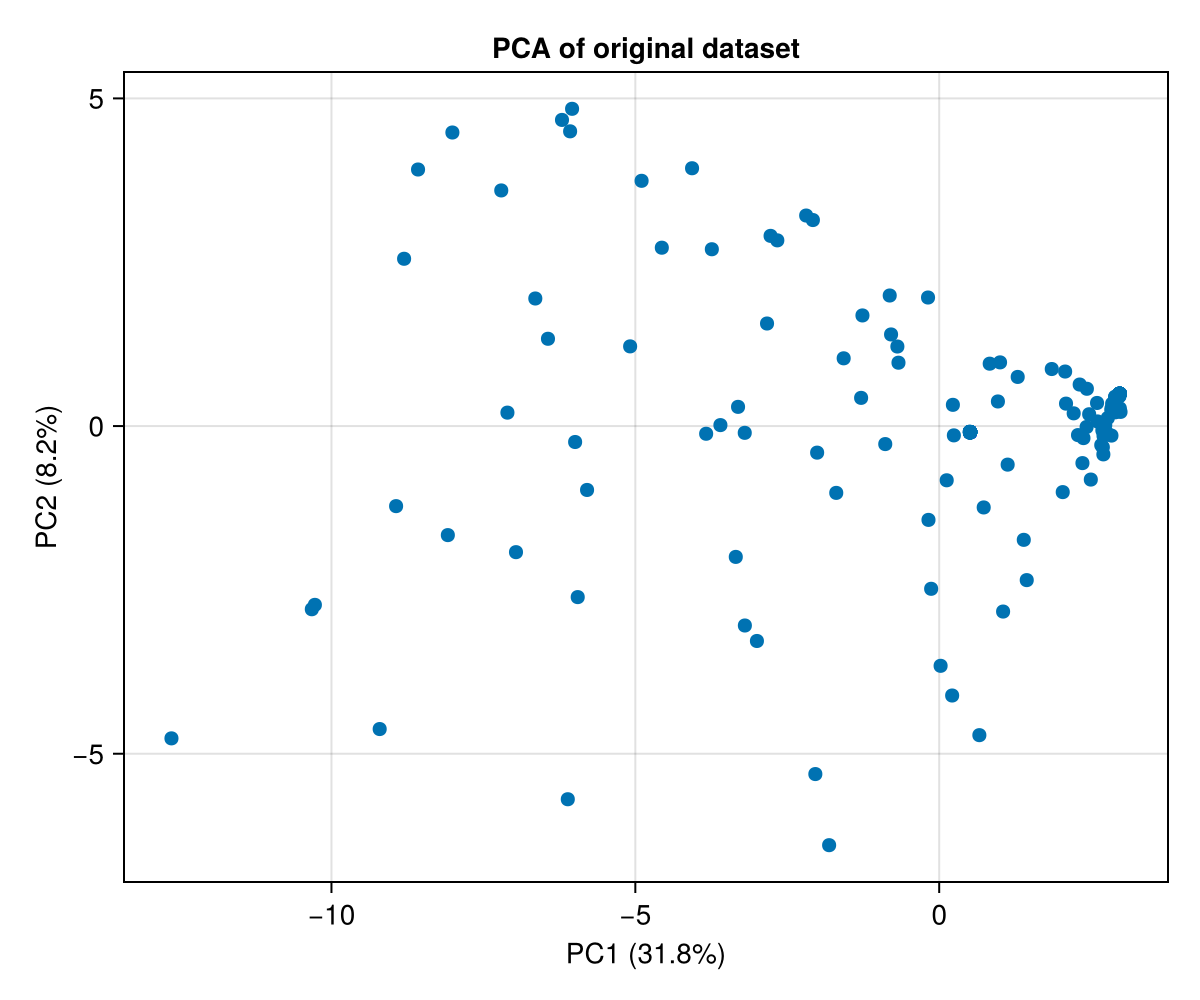

In [ ]:
function pca_data(X::Matrix{Float64};
                  n_components::Int = 2,
                  center::Bool = true,
                  scale::Bool = false)

    Xc = center ? X .- mean(X, dims=1) : X
    Xcs = scale  ? Xc ./ std(Xc, dims=1) : Xc

    # Covariance matrix (features × features)
    C = cov(Xcs; dims=1)

    # Eigen-decomposition
    eig = eigen(Symmetric(C))
    idx = sortperm(eig.values, rev=true)

    values = eig.values[idx]
    vectors = eig.vectors[:, idx]

    loadings = vectors[:, 1:n_components]          # p × k
    Z_pca = Xcs * loadings                          # n × k
    explained_var = values[1:n_components] / sum(values)

    return Z_pca, loadings, explained_var
end

X, feature_names = prepare_data(data_Gogl)

# Impute missing values
X_filled = impute_mean(X)

# Run PCA
Z_pca, loadings, explained_var = pca_data(X_filled; n_components=2)

println("Explained variance (%): ",
        round.(explained_var .* 100, digits=2))


fig = Figure(resolution = (600, 500))
ax = Axis(
    fig[1, 1],
    xlabel = "PC1 ($(round(explained_var[1]*100, digits=1))%)",
    ylabel = "PC2 ($(round(explained_var[2]*100, digits=1))%)",
    title  = "PCA on plain biding profiles"
)

scatter!(
    ax,
    Z_pca[:, 1],
    Z_pca[:, 2];
    markersize = 10
)

fig
